# Предсказание рисков сердечного приступа

## Описание проекта

В этом проекте необходимо разработать модель для предсказания риска сердечного приступа, используя данные пациентов, такие как возраст, привычки, состояние здоровья и результаты анализа крови. Предполагается работа с датасетом из открытого источника. В начале проекта будет доступен обучающий датасет и тестовый датасет, не содержащий правильных ответов, для которого нужно будет подготовить предсказания. 

## Цель проекта

Разработать модель машинного обучения для предсказания риска сердечного приступа, а также подготовить библиотеку и интерфейс к ней для предсказания на тестовой выборке.

## Описание данных

Файлы **heart_train.csv** и **heart_test.csv** содержат данные пациентов для предсказания риска сердечных приступов:

* Антропометрические параметры (возраст, ИМТ);
* Привычки (курение, алкогольная зависимость, физическая активность, качество сна, диета и т.п.);
* Медицинские показатели (давление, уровень холестерина, триглицериды, пульс );
* Наличие хронических заболеваний (диабет, ожирение, сердечные заболевания, наличие проблем с сердцем у родственников, применение медикаментов);
* Биохимия крови (уровень сахара в крови, ck-mb(уровень фермента для диагностики и мониторинга повреждения сердечной мышцы, особенно при подозрении на инфаркт миокарда), тропонин (белок, повышенный уровень которого указывает на повреждение сердечной мышцы));
* Уровень стресса;
* Таргет - высокий или низкий риск сердечного приступа.

## 1. Загрузка данных

Импортируем необходимые библиотеки, зададим настройки и константы.

In [1]:
#!pip install catboost -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik
import pickle
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (roc_auc_score, 
                             classification_report, 
                             f1_score, 
                             precision_score, 
                             recall_score, 
                             confusion_matrix)
from phik.report import plot_correlation_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

sns.set_style('whitegrid')

RANDOM_STATE = 42
TEST_SIZE = 0.25

Загрузим файлы с данными.

In [3]:
heart_train = pd.read_csv('./data/heart_train.csv')
heart_test = pd.read_csv('./data/heart_test.csv')

In [4]:
def info_df(df):
    '''
    Выводит основную информацию о датафрейме
    '''
    display(df.head(10))
    print('*'*50, '\n')
    display(df.info())
    print('*'*50, '\n')
    print('Количество пропущенных значений:\n', df.isna().sum(), '\n')
    print('*'*50, '\n')
    print('Количество явных дубликатов:', df.duplicated().sum())

In [5]:
info_df(heart_train)

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047
5,5,0.168539,0.764286,0.057745,0.0,1.0,1.0,1.0,1.0,0.082682,1,1.0,0.0,7.0,0.558262,0.640836,0.110571,0.238961,6.0,0.833333,0.0,0.227018,0.048229,0.036512,Male,0.464516,0.418605,5817
6,6,0.483146,0.021429,0.036664,1.0,0.0,1.0,0.0,1.0,0.540206,2,0.0,1.0,9.0,0.827611,0.774609,0.073718,0.072727,5.0,0.000000,1.0,0.231225,0.008940,0.000291,Male,0.361290,0.569767,5580
7,7,0.235955,0.939286,0.081577,1.0,0.0,1.0,0.0,1.0,0.290837,2,0.0,1.0,7.0,0.225275,0.999364,0.001534,0.180519,4.0,0.000000,0.0,0.227018,0.048229,0.036512,Male,0.690323,0.639535,4963
8,8,0.685393,0.317857,0.039413,0.0,0.0,1.0,0.0,0.0,0.803160,0,1.0,1.0,3.0,0.828176,0.142208,0.093073,0.990909,6.0,0.166667,1.0,0.126482,0.002332,0.007185,Male,0.664516,0.616279,4521
9,9,0.213483,0.796429,0.076994,1.0,1.0,1.0,1.0,0.0,0.506971,1,0.0,0.0,7.0,0.692973,0.820952,0.145447,0.171429,3.0,1.000000,0.0,0.227018,0.048229,0.036512,Male,0.651613,0.720930,2455


************************************************** 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems      

None

************************************************** 

Количество пропущенных значений:
 Unnamed: 0                           0
Age                                  0
Cholesterol                          0
Heart rate                           0
Diabetes                           243
Family History                     243
Smoking                            243
Obesity                            243
Alcohol Consumption                243
Exercise Hours Per Week              0
Diet                                 0
Previous Heart Problems            243
Medication Use                     243
Stress Level                       243
Sedentary Hours Per Day              0
Income                               0
BMI                                  0
Triglycerides                        0
Physical Activity Days Per Week    243
Sleep Hours Per Day                  0
Heart Attack Risk (Binary)           0
Blood sugar                          0
CK-MB                                0
Troponin        

**В первом датафрейме** содержится 8685 строк и 28 столбцов и представленны данные о пациентах:

* антропометрические параметры ('Age', 'Gender', 'BMI');
* привычки ('Smoking', 'Alcohol Consumption', 'Exercise Hours Per Week', 'Diet', 'Sedentary Hours Per Day', 'Physical Activity Days Per Week', 'Sleep Hours Per Day');
* давление ('Systolic blood pressure', 'Diastolic blood pressure');
* наличие хронических заболеваний ('Diabetes', 'Obesity');
* биохимические показатели крови ('Cholesterol', 'Triglycerides', 'Blood sugar', 'CK-MB', 'Troponin');
* другие показатели ('Heart rate', 'Family History', 'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Income');
* и целевой признак - высокий или низкий риск поражения сердца ('Heart Attack Risk (Binary)').

Данные в таблице соответствуют описанию. Видно, что количественные показатели нормализованы.

Есть пропущенные значения в столбцах `'Diabetes'`, `'Family History'`, `'Smoking'`, `'Obesity'`, `'Alcohol Consumption'`, `'Previous Heart Problems'`,`'Medication Use'` и `'Stress Level'`. Причем количество пропусков в этих строках одинаковое (243), скорее всего эти данные отсутствуют в одних и тех же строках. Проверим это позже.

Явных дубликатов не выявлено.

Типы данных в столбцах `'Diabetes'`, `'Family History'`, `'Smoking'`, `'Obesity'`, `'Alcohol Consumption'`, `'Previous Heart Problems'`,`'Medication Use'`, `'Stress Level'`, `'Physical Activity Days Per Week'` и `'Heart Attack Risk (Binary)'` нужно будет заменить на целочисленный (int).

Также можно будет переименовать столбцы и привести их к единому виду.

In [6]:
info_df(heart_test)

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,2,0.0,0.0,8.0,0.194370,0.587759,0.283490,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,2,1.0,1.0,5.0,0.329888,0.602883,0.467036,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,0,0.0,0.0,10.0,0.780075,0.370436,0.409366,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,0,0.0,0.0,10.0,0.785071,0.368242,0.910261,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,0,0.0,0.0,7.0,0.070919,0.729578,0.758924,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825
5,5,0.561798,0.792857,0.026581,1.0,1.0,1.0,1.0,0.0,0.774470,2,0.0,1.0,8.0,0.044114,0.813517,0.723416,0.362338,1.0,0.666667,0.227018,0.048229,0.036512,Male,0.161290,0.593023,1076
6,6,0.674157,0.853571,0.019248,1.0,1.0,1.0,0.0,1.0,0.149123,1,0.0,0.0,8.0,0.305998,0.562542,0.696128,0.211688,3.0,0.000000,0.227018,0.048229,0.036512,Male,0.535484,0.546512,5020
7,7,0.539326,0.335714,0.036664,1.0,1.0,1.0,0.0,1.0,0.329720,1,1.0,0.0,1.0,0.377016,0.235091,0.484368,0.835065,7.0,0.666667,0.695652,0.002466,0.000874,Male,0.496774,0.662791,4267
8,8,0.449438,0.328571,0.075160,1.0,0.0,1.0,0.0,0.0,0.487405,2,1.0,0.0,10.0,0.089371,0.486634,0.409407,0.819481,2.0,0.166667,0.227018,0.048229,0.036512,Male,0.677419,0.430233,4003
9,9,0.617978,0.728571,0.032081,0.0,1.0,1.0,0.0,0.0,0.211485,2,1.0,1.0,8.0,0.524318,0.083936,0.657387,0.196104,0.0,1.000000,0.227018,0.048229,0.036512,Male,0.722581,0.255814,2519


************************************************** 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       966 non-null    int64  
 1   Age                              966 non-null    float64
 2   Cholesterol                      966 non-null    float64
 3   Heart rate                       966 non-null    float64
 4   Diabetes                         935 non-null    float64
 5   Family History                   935 non-null    float64
 6   Smoking                          935 non-null    float64
 7   Obesity                          935 non-null    float64
 8   Alcohol Consumption              935 non-null    float64
 9   Exercise Hours Per Week          966 non-null    float64
 10  Diet                             966 non-null    int64  
 11  Previous Heart Problems        

None

************************************************** 

Количество пропущенных значений:
 Unnamed: 0                          0
Age                                 0
Cholesterol                         0
Heart rate                          0
Diabetes                           31
Family History                     31
Smoking                            31
Obesity                            31
Alcohol Consumption                31
Exercise Hours Per Week             0
Diet                                0
Previous Heart Problems            31
Medication Use                     31
Stress Level                       31
Sedentary Hours Per Day             0
Income                              0
BMI                                 0
Triglycerides                       0
Physical Activity Days Per Week    31
Sleep Hours Per Day                 0
Blood sugar                         0
CK-MB                               0
Troponin                            0
Gender                              0
S

**Во втором датафрейме** содержится 966 строк и 27 столбцов и представленны такие же данные о пациентах, как и в первом датафрейме, за исключением целевого признака.

Данные в таблице соответствуют описанию. Видно, что количественные показатели нормализованы.

Как и в первом датафрейме, есть пропущенные значения в столбцах `'Diabetes'`, `'Family History'`, `'Smoking'`, `'Obesity'`, `'Alcohol Consumption'`, `'Previous Heart Problems'`,`'Medication Use'` и `'Stress Level'` (по 31 пропуску), скорее всего эти данные отсутствуют в одних и тех же строках. 

Явных дубликатов не выявлено.

Типы данных в столбцах `'Diabetes'`, `'Family History'`, `'Smoking'`, `'Obesity'`, `'Alcohol Consumption'`, `'Previous Heart Problems'`,`'Medication Use'`, `'Stress Level'` и `'Physical Activity Days Per Week'` тоже нужно будет заменить на целочисленный (int).

Также можно будет переименовать столбцы и привести их к единому виду.

## 2. Предобработка данных

### 'heart_train'

Приведем названия столбцов к нижнему регистру и змеиному стилю. Также удалим столбец `'Unnamed: 0'`, так как в нем содержатся порядковые номера строк и установим в качестве индекса `'id'`.

In [7]:
heart_train.columns = heart_train.columns.str.lower().str.replace(' ', '_')
heart_train.columns

Index(['unnamed:_0', 'age', 'cholesterol', 'heart_rate', 'diabetes',
       'family_history', 'smoking', 'obesity', 'alcohol_consumption',
       'exercise_hours_per_week', 'diet', 'previous_heart_problems',
       'medication_use', 'stress_level', 'sedentary_hours_per_day', 'income',
       'bmi', 'triglycerides', 'physical_activity_days_per_week',
       'sleep_hours_per_day', 'heart_attack_risk_(binary)', 'blood_sugar',
       'ck-mb', 'troponin', 'gender', 'systolic_blood_pressure',
       'diastolic_blood_pressure', 'id'],
      dtype='object')

In [8]:
heart_train = heart_train.drop('unnamed:_0', axis=1).set_index('id')
heart_train.head()

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure
id,,,,,,,,,,,,,,,,,,,,,,,,,,
2664,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302
9287,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767
5379,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930
8222,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442
4047,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860


Для удобства переместим столбец с целевым признаком в начало датафрейма.

In [9]:
target = heart_train['heart_attack_risk_(binary)']
heart_train = heart_train.drop('heart_attack_risk_(binary)', axis=1)
heart_train.insert(0, 'heart_attack_risk_(binary)', target)
heart_train.sample(5)

,heart_attack_risk_(binary),age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure
id,,,,,,,,,,,,,,,,,,,,,,,,,,
6918,1.0,0.078652,0.810714,0.065078,1.0,1.0,1.0,1.0,1.0,0.204364,0,1.0,0.0,3.0,0.032011,0.897668,0.989480,0.335065,0.0,0.833333,0.227018,0.048229,0.036512,Male,0.277419,0.348837
2713,1.0,0.797753,0.346429,0.055912,0.0,1.0,1.0,0.0,1.0,0.269885,2,1.0,1.0,2.0,0.212450,0.889597,0.437868,0.105195,3.0,0.666667,0.227018,0.048229,0.036512,Male,0.225806,0.430233
3259,0.0,0.202247,0.560714,0.030247,0.0,1.0,0.0,1.0,1.0,0.241110,1,0.0,1.0,4.0,0.415150,0.871168,0.506070,0.559740,4.0,0.833333,0.227018,0.048229,0.036512,Female,0.503226,0.546512
3558,1.0,0.741573,0.507143,0.036664,0.0,0.0,1.0,0.0,1.0,0.167656,2,0.0,1.0,3.0,0.621906,0.559952,0.037298,0.909091,4.0,0.166667,0.258893,0.010475,0.189242,Female,0.483871,0.406977
5294,0.0,0.056180,0.157143,0.075160,1.0,1.0,0.0,1.0,1.0,0.514357,2,0.0,1.0,2.0,0.620549,0.067855,0.070138,0.357143,4.0,0.166667,0.227018,0.048229,0.036512,Female,0.658065,0.209302


В таблице есть ряд столбцов, которые можно привести к целочисленному типу данных int. Проверим, какие в этих столбцах значения, а также проверим значения столбца `'gender'`.

In [10]:
for i in ['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'diet', 'previous_heart_problems', 'medication_use', 'stress_level',
          'physical_activity_days_per_week', 'heart_attack_risk_(binary)', 'gender']:
    print(f'{i}: {heart_train[i].unique()}')

diabetes: [ 1.  0. nan]
family_history: [ 1.  0. nan]
smoking: [ 1.  0. nan]
obesity: [ 1.  0. nan]
alcohol_consumption: [ 1.  0. nan]
diet: [1 2 0 3]
previous_heart_problems: [ 1.  0. nan]
medication_use: [ 0.  1. nan]
stress_level: [ 8.  9.  6.  3.  7.  1. 10. nan  2.  5.  4.]
physical_activity_days_per_week: [ 3.  2.  0.  5.  6.  4.  7. nan  1.]
heart_attack_risk_(binary): [0. 1.]
gender: ['Male' 'Female' '1.0' '0.0']


После обработки пропусков можно будет изменить типы данных на целочисленный в столбцах `'diabetes'`, `'family_history'`, `'smoking'`, `'obesity'`, `'alcohol_consumption'`, `'previous_heart_problems'`, `'medication_use'`, `'stress_level'`, `'physical_activity_days_per_week'` и целевом признаке `'heart_attack_risk_(binary)'`.

Также видно, что во всех признаках, кроме `'gender'`, нет неявных дубликатов.

В столбце с полом `'gender'` помимо значений 'Male'/'Female' есть также значения '1.0' и '0.0'. Мы не знаем, какой именно пол отнесли к '1.0'. Посмотрим, как много таких значений.

In [11]:
heart_train['gender'].value_counts()

gender
Male      5882
Female    2560
1.0        156
0.0         87
Name: count, dtype: int64

Видим, что количество строк со значениями '1.0' и '0.0' - 243. Количество такое же, как и с пропусками. Возможно, что эти значения находятся в тех же самых строках. Проверим, так ли это.

In [12]:
print('Общее количество строк с пропусками:', (heart_train.isnull().sum(axis=1) > 0).sum())
print('Количество строк с пропусками и неочевидными значениями:', \
heart_train[(heart_train.isna().any(axis=1)) | (heart_train['gender'].isin(['1.0', '0.0']))].shape[0])
print(f'Доля пропусков: {(heart_train.isnull().sum(axis=1) > 0).sum() / heart_train.shape[0]:.2%}')

Общее количество строк с пропусками: 243
Количество строк с пропусками и неочевидными значениями: 243
Доля пропусков: 2.80%


Так как пропуски у нас в медицинских данных и мы не можем их восстановить, замена их медианными значениями может исказить результаты, и доля пропусков небольшая - 243 строки (2.8%) из 8685 строк, самым лучшим вариантом, на мой взгляд, будет просто удалить строки с пропущенными значениями.

In [13]:
print(f'Размерность датасета до удаления строк: {heart_train.shape}')
df_train = heart_train.dropna()
print(f'Размерность датасета после удаления строк: {df_train.shape}')
print('Количество пропусков:')
df_train.isna().sum()

Размерность датасета до удаления строк: (8685, 26)
Размерность датасета после удаления строк: (8442, 26)
Количество пропусков:


heart_attack_risk_(binary)         0
age                                0
cholesterol                        0
heart_rate                         0
diabetes                           0
family_history                     0
smoking                            0
obesity                            0
alcohol_consumption                0
exercise_hours_per_week            0
diet                               0
previous_heart_problems            0
medication_use                     0
stress_level                       0
sedentary_hours_per_day            0
income                             0
bmi                                0
triglycerides                      0
physical_activity_days_per_week    0
sleep_hours_per_day                0
blood_sugar                        0
ck-mb                              0
troponin                           0
gender                             0
systolic_blood_pressure            0
diastolic_blood_pressure           0
dtype: int64

Теперь изменим типы данных.

In [14]:
columns_change_type = ['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'previous_heart_problems', 'medication_use', \
'stress_level', 'physical_activity_days_per_week', 'heart_attack_risk_(binary)']
df_train[columns_change_type] = df_train[columns_change_type].astype(int)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8442 entries, 2664 to 7270
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   heart_attack_risk_(binary)       8442 non-null   int64  
 1   age                              8442 non-null   float64
 2   cholesterol                      8442 non-null   float64
 3   heart_rate                       8442 non-null   float64
 4   diabetes                         8442 non-null   int64  
 5   family_history                   8442 non-null   int64  
 6   smoking                          8442 non-null   int64  
 7   obesity                          8442 non-null   int64  
 8   alcohol_consumption              8442 non-null   int64  
 9   exercise_hours_per_week          8442 non-null   float64
 10  diet                             8442 non-null   int64  
 11  previous_heart_problems          8442 non-null   int64  
 12  medication_use        

### 'heart_test'

Приведем названия столбцов к нижнему регистру и змеиному стилю. Также удалим столбец `'Unnamed: 0'`, так как в нем содержатся порядковые номера строк и установим в качестве индекса `'id'`.

In [15]:
heart_test.columns = heart_test.columns.str.lower().str.replace(' ', '_')
heart_test.columns

Index(['unnamed:_0', 'age', 'cholesterol', 'heart_rate', 'diabetes',
       'family_history', 'smoking', 'obesity', 'alcohol_consumption',
       'exercise_hours_per_week', 'diet', 'previous_heart_problems',
       'medication_use', 'stress_level', 'sedentary_hours_per_day', 'income',
       'bmi', 'triglycerides', 'physical_activity_days_per_week',
       'sleep_hours_per_day', 'blood_sugar', 'ck-mb', 'troponin', 'gender',
       'systolic_blood_pressure', 'diastolic_blood_pressure', 'id'],
      dtype='object')

In [16]:
heart_test = heart_test.drop('unnamed:_0', axis=1).set_index('id')
heart_test.head()

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure
id,,,,,,,,,,,,,,,,,,,,,,,,,
7746,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,2,0.0,0.0,8.0,0.194370,0.587759,0.283490,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093
4202,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,2,1.0,1.0,5.0,0.329888,0.602883,0.467036,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860
6632,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,0,0.0,0.0,10.0,0.780075,0.370436,0.409366,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070
4639,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,0,0.0,0.0,10.0,0.785071,0.368242,0.910261,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814
4825,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,0,0.0,0.0,7.0,0.070919,0.729578,0.758924,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349


В таблице есть ряд столбцов, которые можно привести к целочисленному типу данных int. Проверим, какие в этих столбцах значения, а также проверим значения столбца `'gender'`.

In [17]:
for i in ['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'diet', 'previous_heart_problems', 'medication_use', 'stress_level',
          'physical_activity_days_per_week', 'gender']:
    print(f'{i}: {heart_test[i].unique()}')

diabetes: [ 0.  1. nan]
family_history: [ 1.  0. nan]
smoking: [ 1.  0. nan]
obesity: [ 1.  0. nan]
alcohol_consumption: [ 1.  0. nan]
diet: [2 0 1 3]
previous_heart_problems: [ 0.  1. nan]
medication_use: [ 0.  1. nan]
stress_level: [ 8.  5. 10.  7.  1.  4.  9.  6.  3. nan  2.]
physical_activity_days_per_week: [ 1.  0.  7.  5.  3.  2.  4.  6. nan]
gender: ['Male' 'Female' '1.0' '0.0']


Так же, как и в предыдущем датасете, в столбце с полом `'gender'` помимо значений 'Male'/'Female' есть также значения '1.0' и '0.0'. Неявных дубликатов в остальных столбцах нет. Проверим, сколько строк с пропусками и неизвестным гендером.

In [18]:
print('Общее количество строк с пропусками:', (heart_test.isnull().sum(axis=1) > 0).sum())
print('Количество строк с пропусками и неочевидными значениями:', \
heart_test[(heart_test.isna().any(axis=1)) | (heart_test['gender'].isin(['1.0', '0.0']))].shape[0])
print(f'Доля пропусков: {(heart_test.isnull().sum(axis=1) > 0).sum() / heart_test.shape[0]:.2%}')

Общее количество строк с пропусками: 31
Количество строк с пропусками и неочевидными значениями: 31
Доля пропусков: 3.21%


Так же, как и в предыдущем датасете, так как количество строк с пропусками небольшое (31 строка (3.21%)) и мы не можем восстановить пропущенные значения, а заменять их, например, медианным значением, будет не очень хорошим решением, удалим эти строки.

In [19]:
print(f'Размерность датасета до удаления строк: {heart_test.shape}')
df_test = heart_test.dropna()
print(f'Размерность датасета после удаления строк: {df_test.shape}')
print('Количество пропусков:')
df_test.isna().sum()

Размерность датасета до удаления строк: (966, 25)
Размерность датасета после удаления строк: (935, 25)
Количество пропусков:


age                                0
cholesterol                        0
heart_rate                         0
diabetes                           0
family_history                     0
smoking                            0
obesity                            0
alcohol_consumption                0
exercise_hours_per_week            0
diet                               0
previous_heart_problems            0
medication_use                     0
stress_level                       0
sedentary_hours_per_day            0
income                             0
bmi                                0
triglycerides                      0
physical_activity_days_per_week    0
sleep_hours_per_day                0
blood_sugar                        0
ck-mb                              0
troponin                           0
gender                             0
systolic_blood_pressure            0
diastolic_blood_pressure           0
dtype: int64

Изменим типы данных на int в тех же столбцах, что и в предыдущем датасете (за исключением целевого признака `'heart_attack_risk_(binary)'`, которого нет в тестовом датасете).

In [20]:
df_test[columns_change_type[:-1]] = df_test[columns_change_type[:-1]].astype(int)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 935 entries, 7746 to 6521
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              935 non-null    float64
 1   cholesterol                      935 non-null    float64
 2   heart_rate                       935 non-null    float64
 3   diabetes                         935 non-null    int64  
 4   family_history                   935 non-null    int64  
 5   smoking                          935 non-null    int64  
 6   obesity                          935 non-null    int64  
 7   alcohol_consumption              935 non-null    int64  
 8   exercise_hours_per_week          935 non-null    float64
 9   diet                             935 non-null    int64  
 10  previous_heart_problems          935 non-null    int64  
 11  medication_use                   935 non-null    int64  
 12  stress_level           

### Вывод:

Проведена предобработка данных:
* были переименованы столбцы и приведены к единому стилю написания;
* обработаны пропущенные значения;
* явных дубликатов не выявлено;
* были удалены неочевидные значения в столбце `'gender'`;
* изменены типы данных.

## 3. Исследовательский анализ данных

In [21]:
def numerical_plot(data_1, data_2, feature, title_1, xlabel, title_2, option=1):
    '''
    Строит гистограмму для непрерывных признаков (option=1) или
    столбчатую диаграмму для дискретных признаков (option=2) 
    и диаграмму размаха  по заданным параметрам
    ''' 
    f, ax = plt.subplots(1, 2, figsize=(16,6))
    
    if option == 1:
        sns.histplot(data_1[feature], bins=30, ax=ax[0], kde=True, label='Тренировочная выборка')
        ax[0].vlines(x=data_1[feature].median(), colors='red', ymin=0, ymax=1, transform=ax[0].get_xaxis_transform(), 
                     lw=3, alpha=0.6, label='Медиана (train)')
        sns.histplot(data_2[feature], bins=30, ax=ax[0], kde=True, label='Тестовая выборка')
        ax[0].vlines(x=data_2[feature].median(), colors='green', ymin=0, ymax=1, transform=ax[0].get_xaxis_transform(), 
                     lw=3, alpha=0.6, label='Медиана (test)')
        ax[0].set_title(title_1)
        ax[0].set_xlabel(xlabel)
        ax[0].set_ylabel('Количество')
        ax[0].legend()
        sns.move_legend(ax[0], "lower center", bbox_to_anchor=(0.5, -0.2), ncol=4, title=None, frameon=False)
        ax[0].grid(True)
        
    if option == 2:
        sns.countplot(data_1, x=feature, ax=ax[0], color='#1f77b4', alpha=0.7, label='Тренировочная выборка')
        sns.countplot(data_2, x=feature, ax=ax[0], color='orange', alpha=0.7, label='Тестовая выборка')
        ax[0].set_title(title_1)
        ax[0].set_xlabel(xlabel)
        ax[0].tick_params(axis='x', labelrotation=30)
        ax[0].set_ylabel('Количество') 
        ax[0].grid(True)
        
        for p in ax[0].patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            ax[0].text(x+width/2, 
                       y+height*1.02, 
                       int(height), 
                       horizontalalignment='center', 
                       verticalalignment='center',
                       fontsize=12)  
    
    ax[1].boxplot([data_1[feature], data_2[feature]], vert=False, labels=['train', 'test'])
    ax[1].set_title(title_2)
    ax[1].set_xlabel(xlabel)
    
    plt.grid(True)
    plt.show()
    
def categoriсal_plot(data, title, ylabel):
    '''
    Строит столбчатую диаграмму для дискретных количественных признаков и категориальных признаков 
    по заданным параметрам
    ''' 
    ax = data.value_counts().sort_index(ascending=False).plot(kind='barh', grid=True, figsize=(12, 5), alpha=0.7)
    plt.title(title)
    plt.xlabel('Количество')
    plt.ylabel(ylabel)
    plt.xticks(rotation=0)

    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width/2, 
                y+height/2, 
                int(width), 
                horizontalalignment='center', 
                verticalalignment='center',
                fontsize=15)
    
    plt.show()
    
    print(data.value_counts(normalize=True).sort_index(ascending=True).map(lambda x: '{:,.2%}'.format(x)))

### 3.1. Анализ количественных признаков

In [22]:
num_col_names = ['age', 'cholesterol', 'heart_rate', 'exercise_hours_per_week', 'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides', \
'physical_activity_days_per_week', 'sleep_hours_per_day', 'blood_sugar', 'ck-mb', 'troponin', 'systolic_blood_pressure', \
'diastolic_blood_pressure']
print('Статистические характеристики данных тренировочной выборки')
display(df_train[num_col_names].describe().T)
print('\nСтатистические характеристики данных тестовой выборки')
df_test[num_col_names].describe().T

Статистические характеристики данных тренировочной выборки


,count,mean,std,min,25%,50%,75%,max
age,8442.0,0.449008,0.232809,0.044944,0.247191,0.460674,0.640449,0.853933
cholesterol,8442.0,0.501108,0.288785,0.000000,0.260714,0.496429,0.750000,1.000000
heart_rate,8442.0,0.050194,0.018442,0.018332,0.034830,0.050412,0.065995,0.082493
exercise_hours_per_week,8442.0,0.503415,0.288881,0.000000,0.253359,0.508244,0.754901,1.000000
sedentary_hours_per_day,8442.0,0.499142,0.289418,0.000000,0.247650,0.492734,0.751047,1.000000
income,8442.0,0.496089,0.288767,0.000000,0.244591,0.496052,0.747603,1.000000
bmi,8442.0,0.496831,0.286599,0.000000,0.247935,0.490801,0.744399,1.000000
triglycerides,8442.0,0.505539,0.290412,0.000000,0.257143,0.507792,0.758442,1.000000
physical_activity_days_per_week,8442.0,3.508292,2.281772,0.000000,2.000000,3.000000,6.000000,7.000000
sleep_hours_per_day,8442.0,0.503712,0.332749,0.000000,0.166667,0.500000,0.833333,1.000000



Статистические характеристики данных тестовой выборки


,count,mean,std,min,25%,50%,75%,max
age,935.0,0.452106,0.233873,0.044944,0.235955,0.460674,0.651685,0.853933
cholesterol,935.0,0.487796,0.286674,0.000000,0.235714,0.485714,0.723214,0.996429
heart_rate,935.0,0.050624,0.018031,0.018332,0.036664,0.050412,0.065995,0.082493
exercise_hours_per_week,935.0,0.490327,0.289584,0.000336,0.235647,0.493305,0.739898,0.998938
sedentary_hours_per_day,935.0,0.506941,0.292561,0.001187,0.247833,0.518151,0.767566,0.999033
income,935.0,0.484060,0.278380,0.003351,0.256395,0.482586,0.721821,0.998885
bmi,935.0,0.476200,0.296775,0.002598,0.211395,0.456156,0.734170,0.999496
triglycerides,935.0,0.486127,0.289200,0.000000,0.243506,0.471429,0.732468,0.998701
physical_activity_days_per_week,935.0,3.443850,2.302778,0.000000,1.000000,3.000000,5.000000,7.000000
sleep_hours_per_day,935.0,0.512834,0.327594,0.000000,0.166667,0.500000,0.833333,1.000000


Из полученных данных видно, что данные нормализованные. Понять, если ли среди них какие-то выбивающиеся / неестественные значения проблематично. Видно, что данные тренировочного датасета по значениям схожи с данными тествового датасета. Медианы и средние практически совпадают, что говорит о том, что выбросов скорее всего нет. Посмотрим на распределения этих признаков.

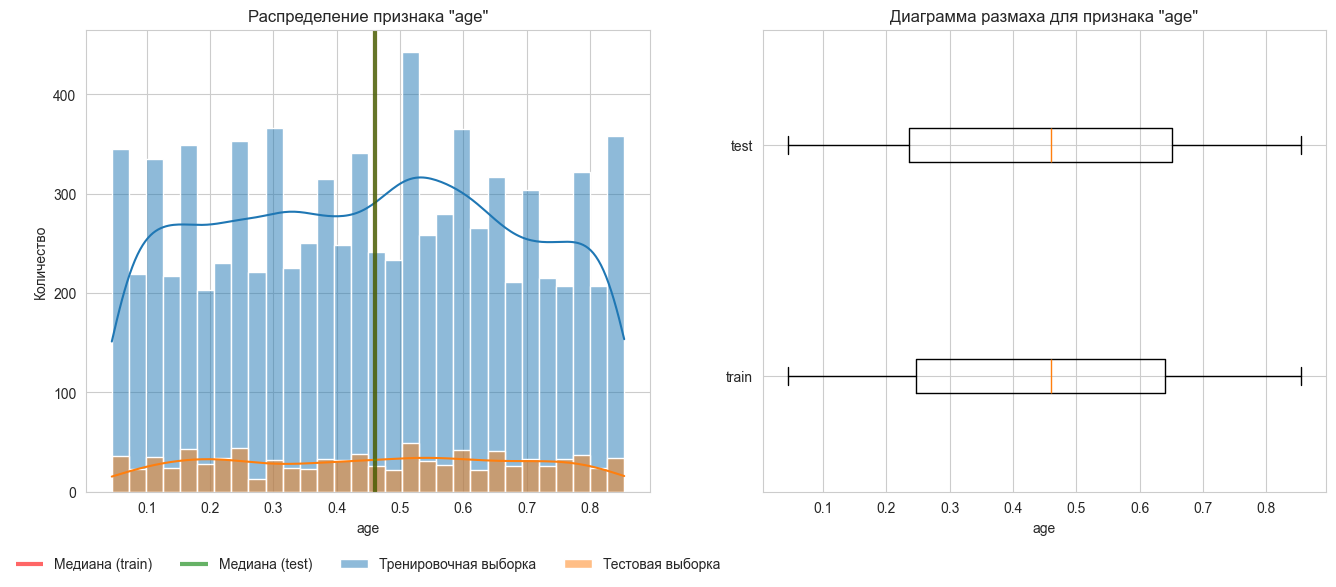

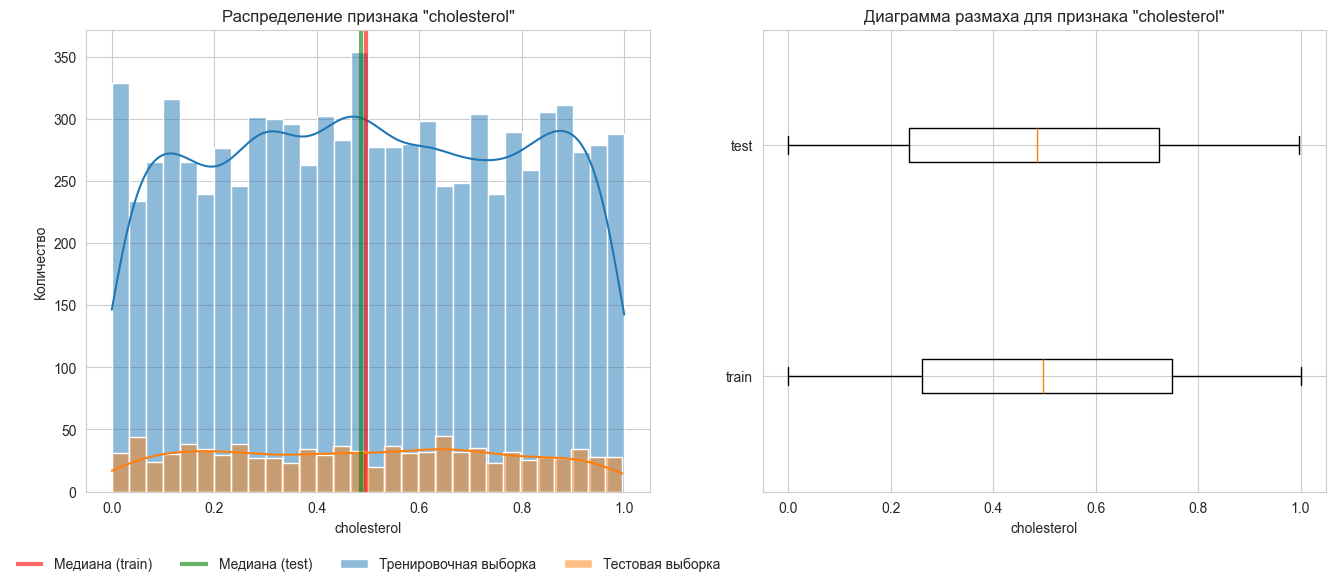

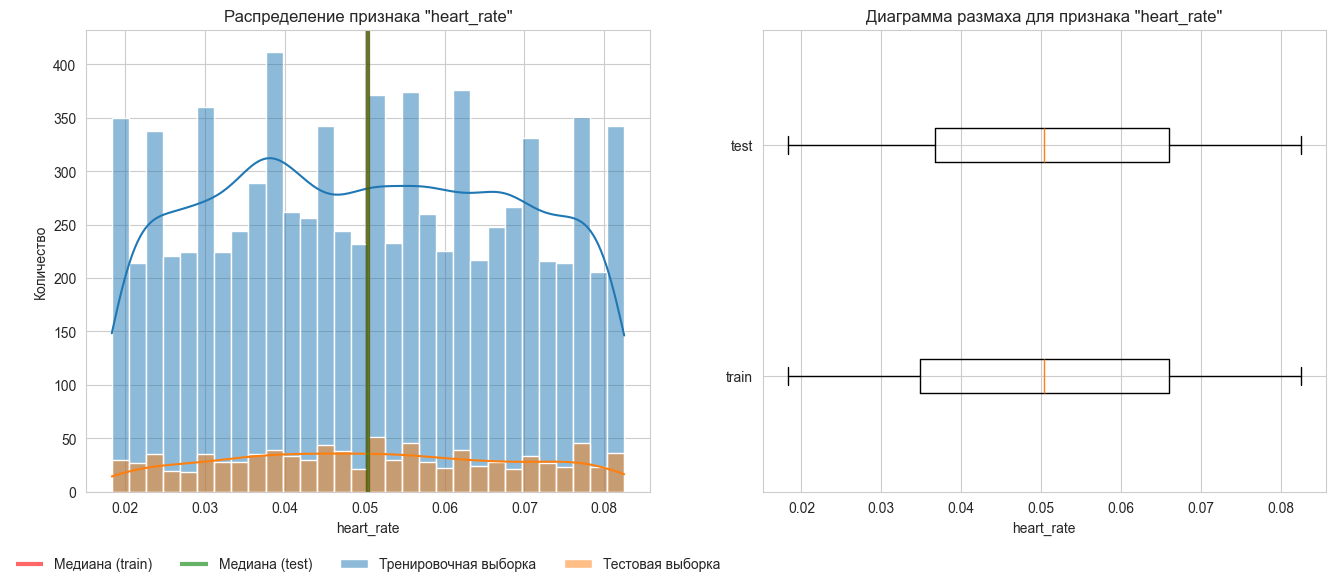

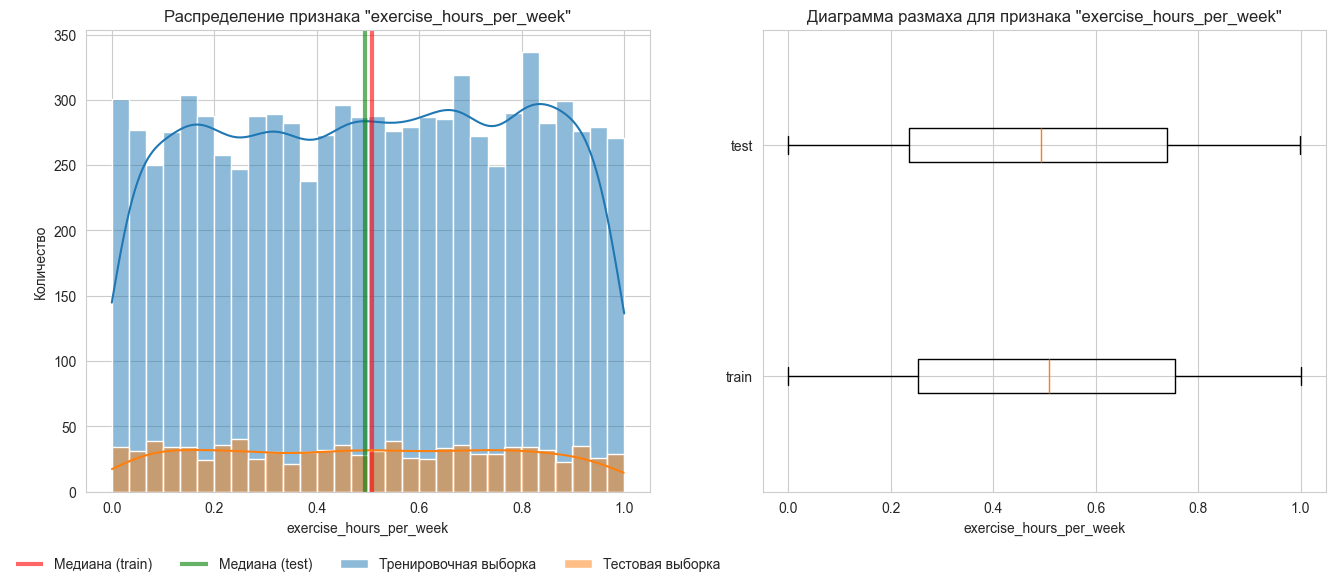

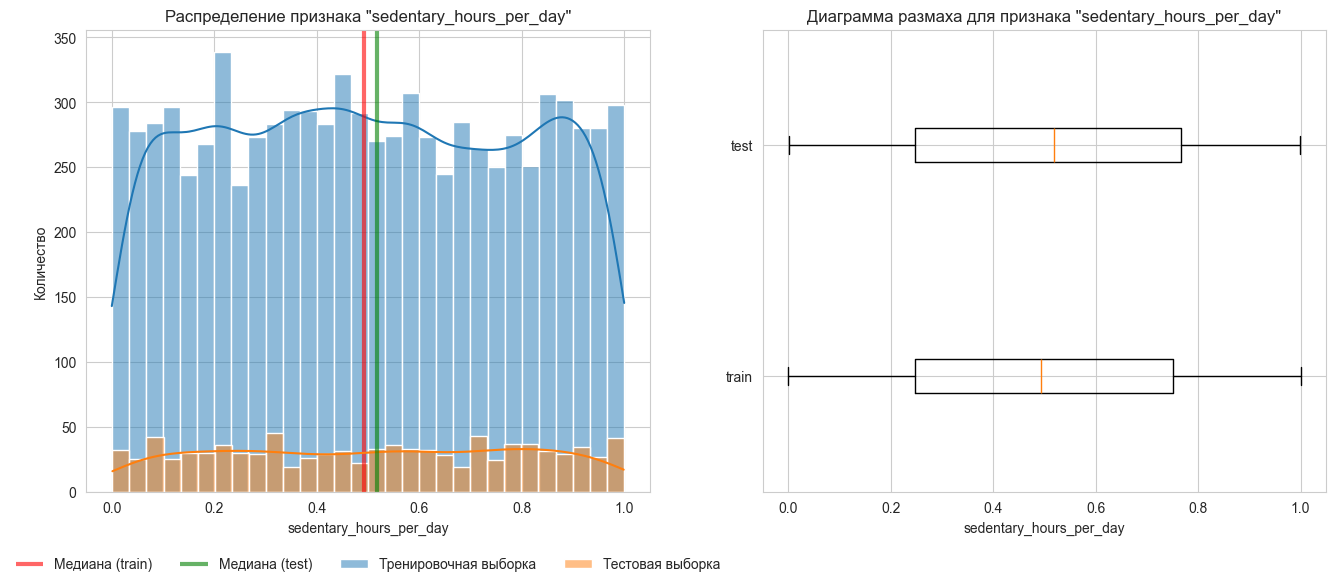

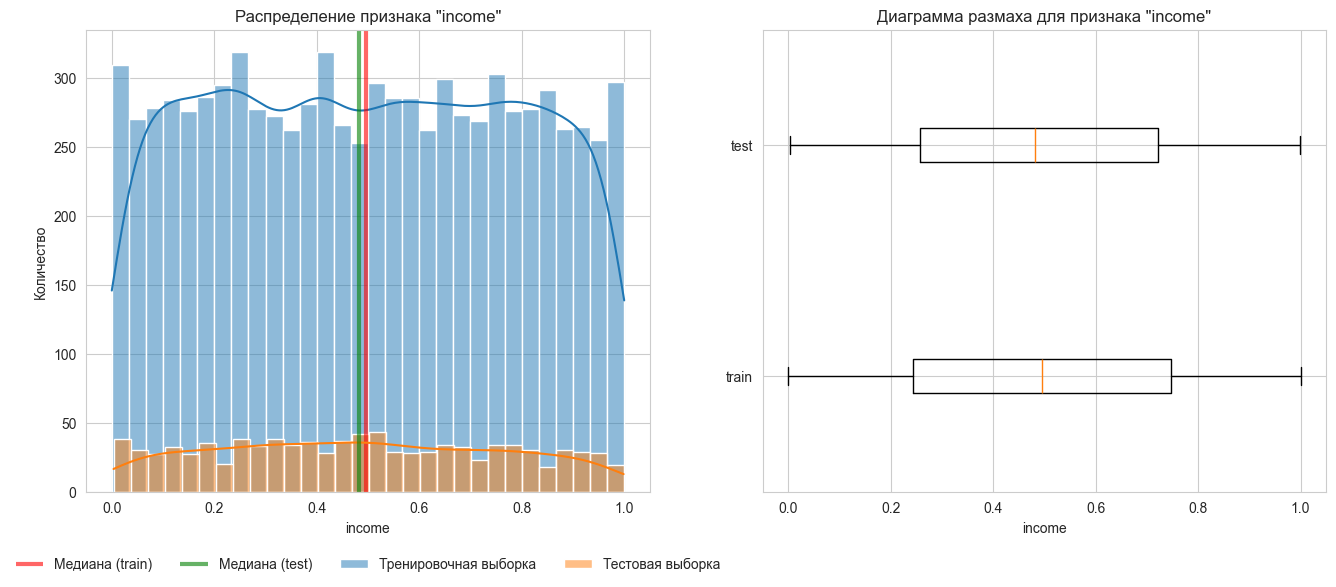

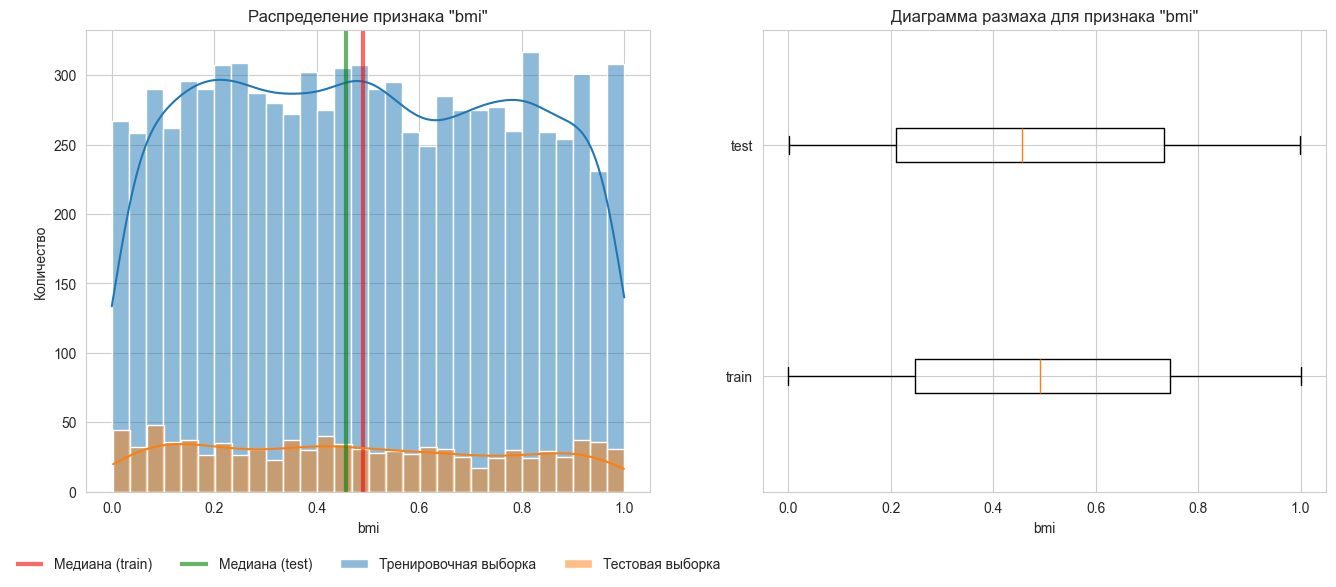

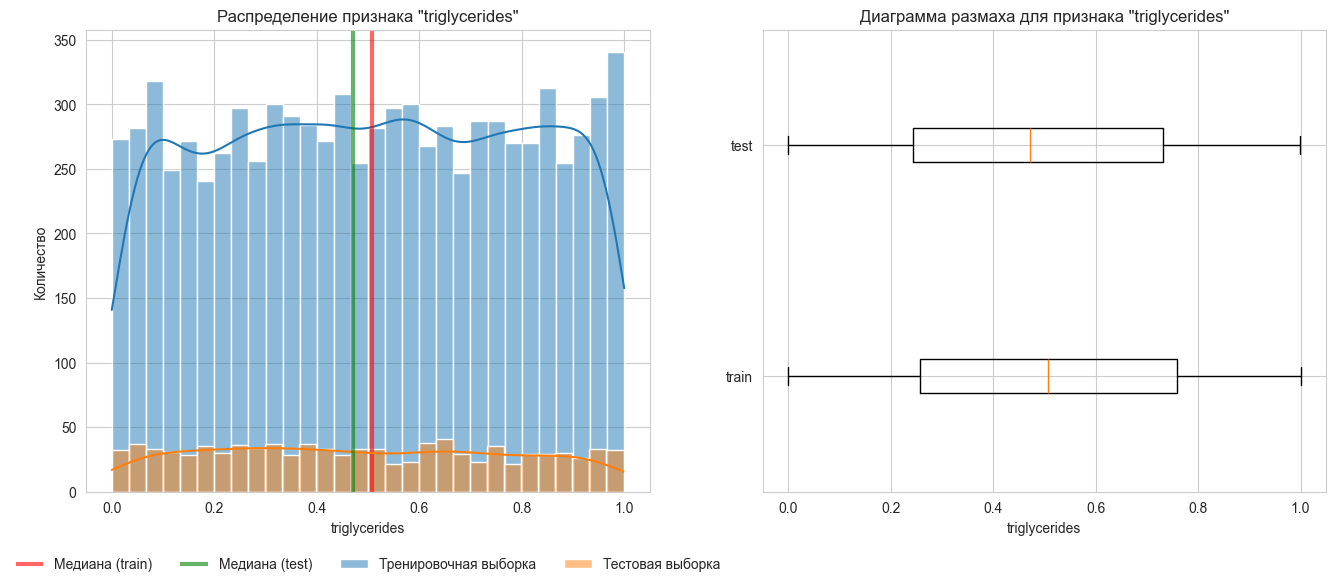

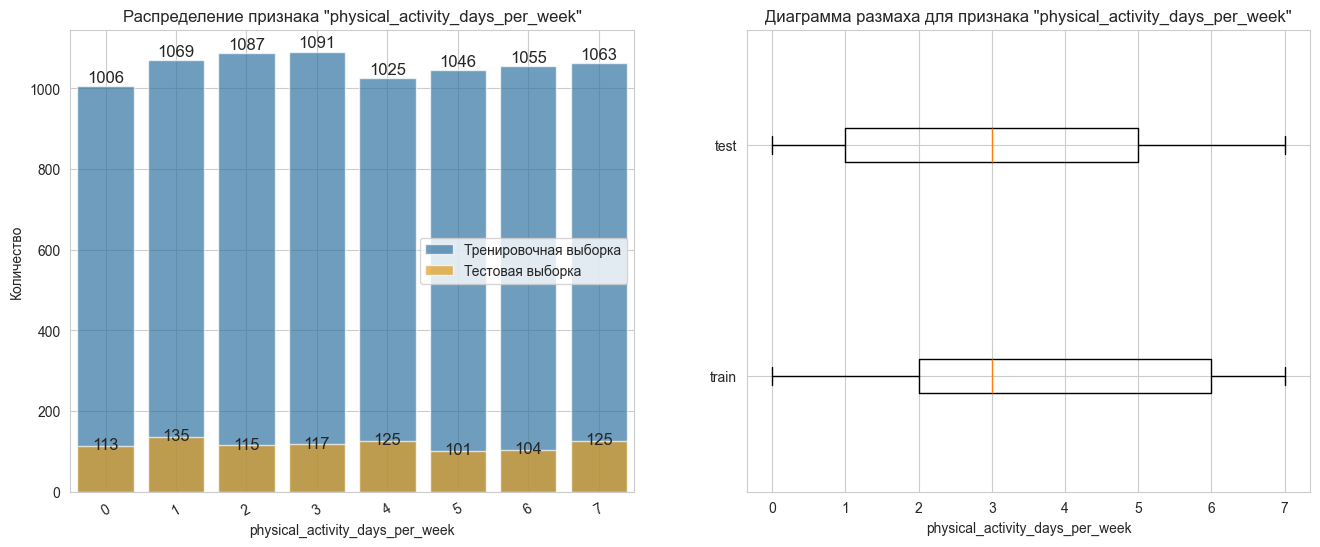

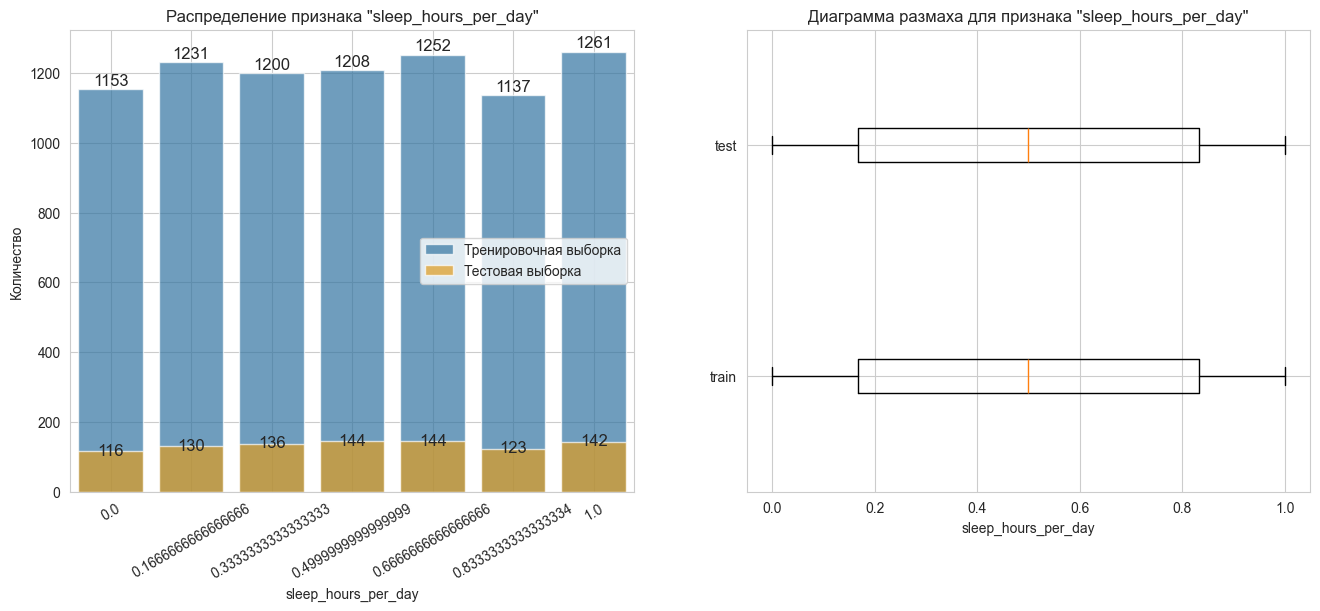

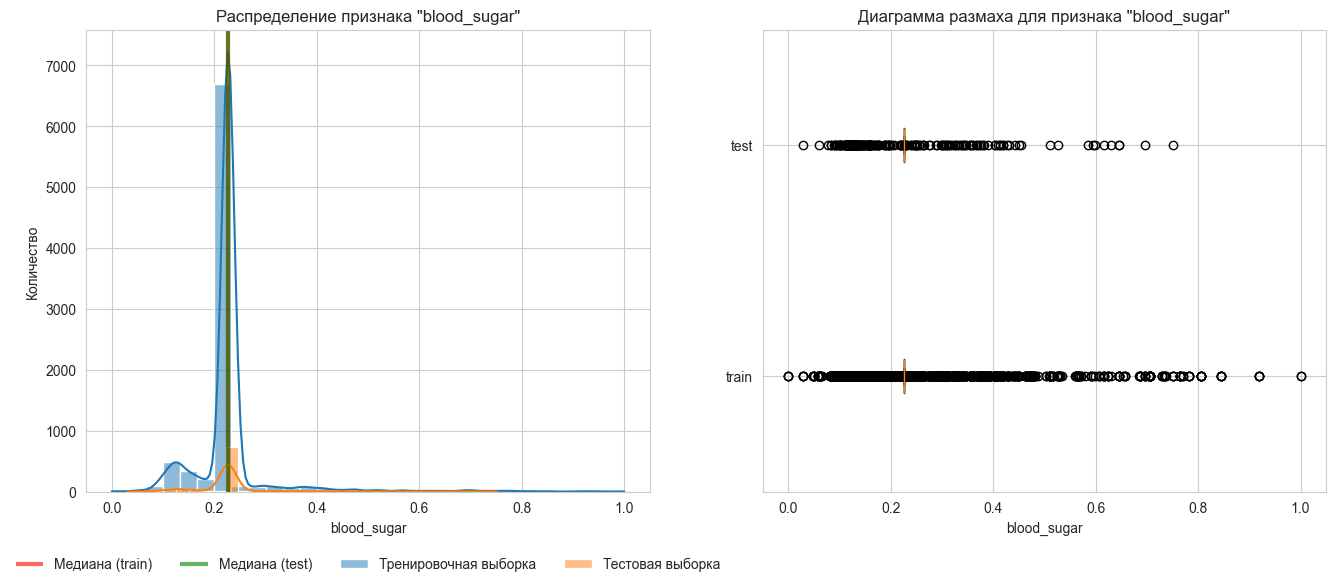

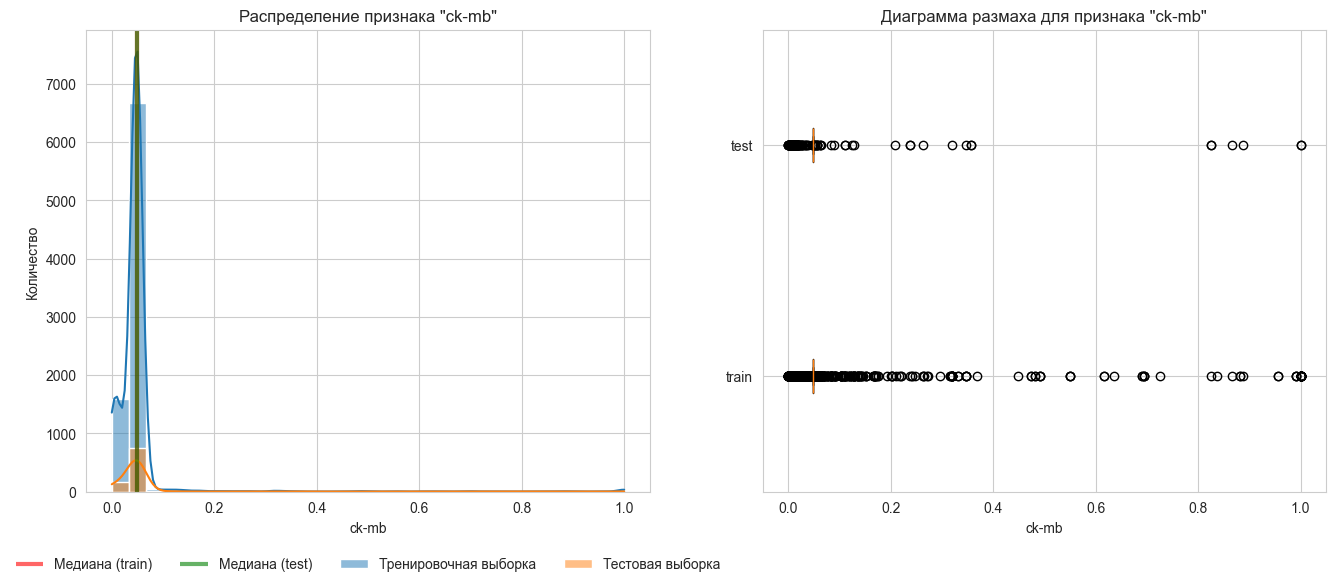

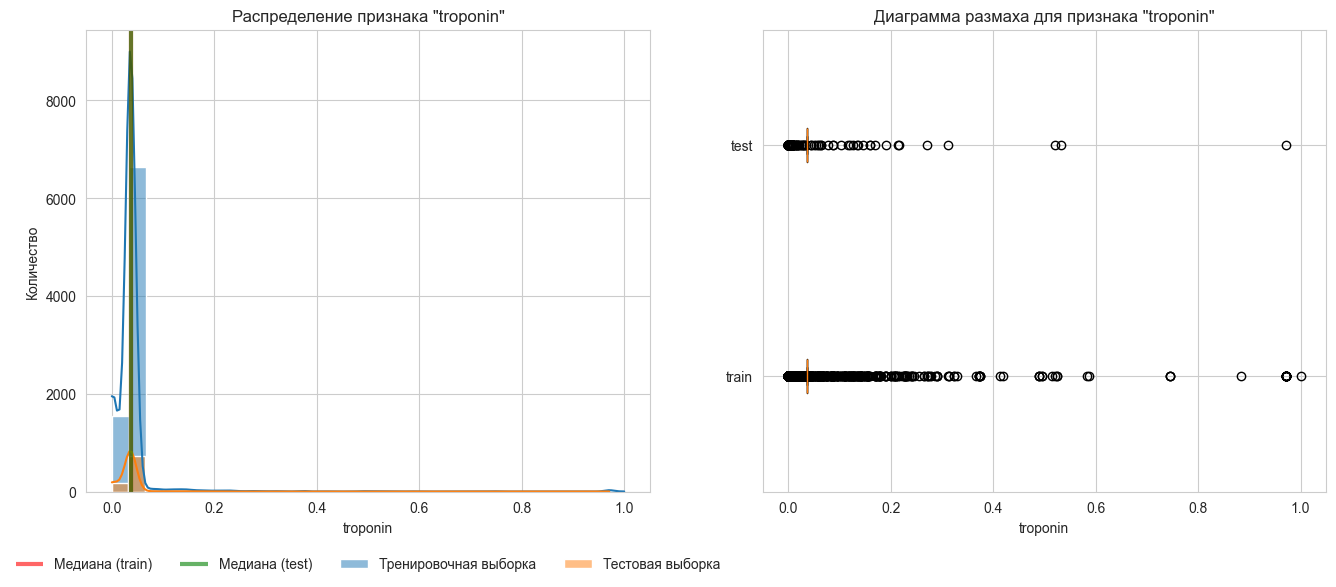

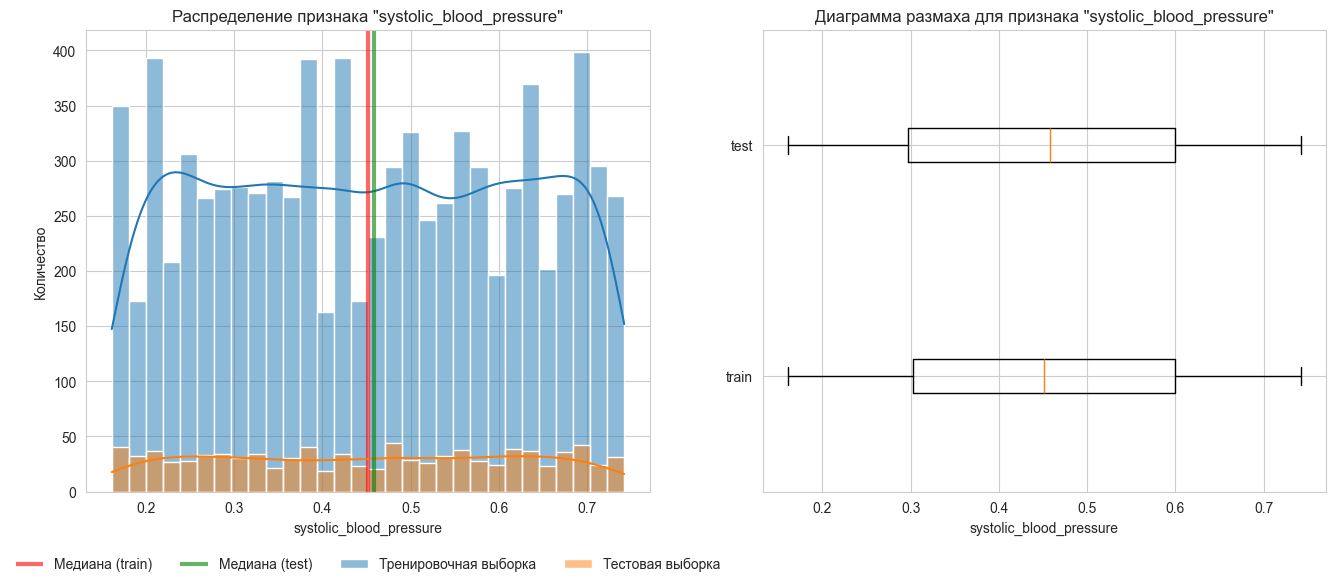

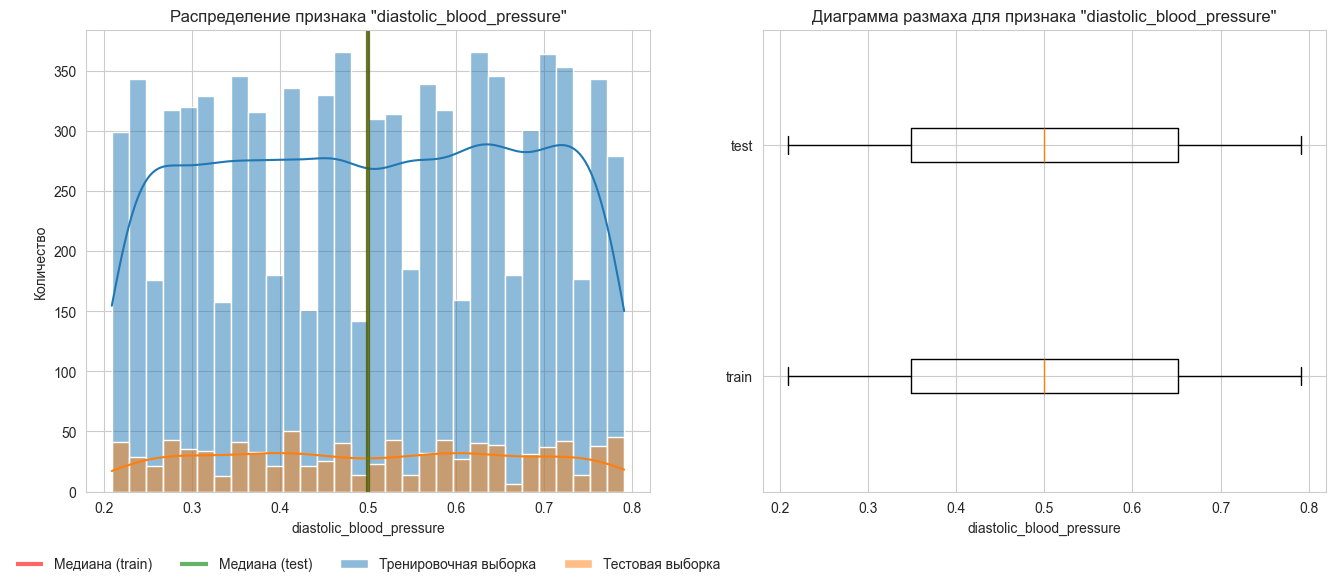

In [23]:
for i in num_col_names:
    if i not in ['sleep_hours_per_day', 'physical_activity_days_per_week']:
        numerical_plot(
            df_train, 
            df_test,
            i, 
            f'Распределение признака "{i}"', 
            f'{i}', 
            f'Диаграмма размаха для признака "{i}"')
    else:
        numerical_plot(
            df_train, 
            df_test,
            i, 
            f'Распределение признака "{i}"', 
            f'{i}', 
            f'Диаграмма размаха для признака "{i}"', 
            option=2)

По графикам видно, что значения тренировочных и тестовых данных очень близки.

Практически у всех признаков (`'age'`, `'cholesterol'`, `'heart_rate'`, `'exercise_hours_per_week'`, `'sedentary_hours_per_day'`, `'income'`, `'bmi'`, `'triglycerides'`, `'sleep_hours_per_day'`, `'systolic_blood_pressure'`, `'diastolic_blood_pressure'`)  распределение равномерное, выбросы отсутствуют. Так как значения уже нормализованы, они лежат в диапазоне от 0 до 1. Но только у признака `'heart_rate'` значения в 10 раз меньше и распределены в диапазоне от 0.02 до 0.08. Учтем это, но пока оставим так.

Данные у дискретных признаков `'physical_activity_days_per_week'` и `'sleep_hours_per_day'` также распределены равномерно, но только у 
`'sleep_hours_per_day'` значения нормализованы и лежат в диапазоне от 0 до 1, а у `'physical_activity_days_per_week'` значения не нормализованы и лежат в диапазоне от 0 до 7. Нужно будет это учесть при построении модели.

У признака `'blood_sugar'` большая часть значений приходится на довольно узкий диапазон (от 0 до 0.5) и есть выбросы. Но из-за того что данные уже нормализованы, мы не знаем, какие значения за ними скрыты. Поэтому пока оставим так и будем смотреть дальше: возможно у этого признаков будет очень слабая корреляция с целевым признаком и его можно будет не учитывать при построении модели, также для оценки качества модели можно использовать нечувствительные к выбросам метрики.

Признаки `'ck-mb'`  и `'troponin'` - это показатели, повышенный уровень которых является следствием инфаркта, а не фактором, увеличивающим риск - утечка целевого признака. Их нужно будет удалить.

Рассмотрим, также, разницу между систолическим и диастолическим давлением (пульсовое давление `'pulse_pressure'`) - она не может быть ниже 0.

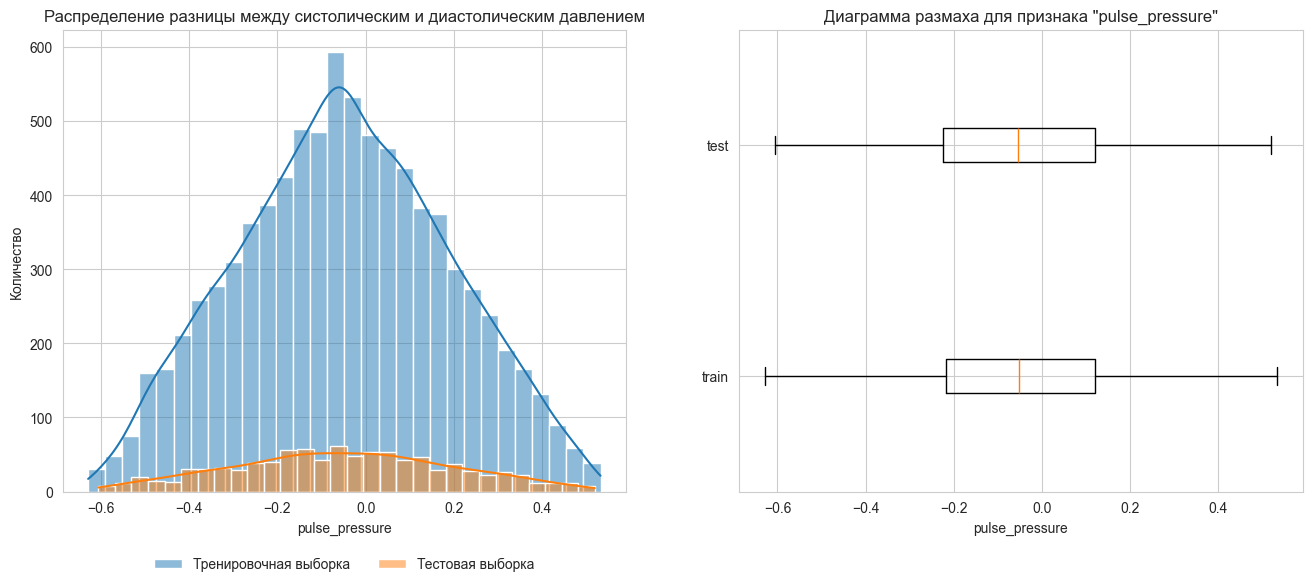

In [24]:
f, ax = plt.subplots(1, 2, figsize=(16,6))

sns.histplot((df_train['systolic_blood_pressure'] - df_train['diastolic_blood_pressure']), bins=30, ax=ax[0], 
             kde=True, label='Тренировочная выборка')
sns.histplot((df_test['systolic_blood_pressure'] - df_test['diastolic_blood_pressure']), bins=30, ax=ax[0], 
             kde=True, label='Тестовая выборка')
ax[0].set_title('Распределение разницы между систолическим и диастолическим давлением')
ax[0].set_xlabel('pulse_pressure')
ax[0].set_ylabel('Количество')
ax[0].legend()
sns.move_legend(ax[0], "lower center", bbox_to_anchor=(0.5, -0.2), ncol=4, title=None, frameon=False)
ax[0].grid(True)
        
ax[1].boxplot([(df_train['systolic_blood_pressure'] - df_train['diastolic_blood_pressure']), 
               (df_test['systolic_blood_pressure'] - df_test['diastolic_blood_pressure'])], 
               vert=False, labels=['train', 'test'])
ax[1].set_title('Диаграмма размаха для признака "pulse_pressure"')
ax[1].set_xlabel('pulse_pressure')
    
plt.grid(True)
plt.show()

Посчитаем количество строк с отрицательной разницей между верхним и нижним давлением.

In [25]:
df_train.query('(systolic_blood_pressure - diastolic_blood_pressure) < 0').shape[0]

4922

Больше половины значений разницы давлений отрицательные, чего быть не должно. Возможно, значения верхнего(систолического) и нижнего(диастолического) давления были переставлены местами. В разделе с построением модели вместо систолического и диастолического давления оставим абсолютные значения `'pulse_pressure'` и добавим категориальный признак наличия гипертонии `'hypertension'`, если нормализованное значение любого из давлений > 0.6, что примерно соответствует > 140 мм рт.ст.

### 3.2. Анализ категориальных признаков

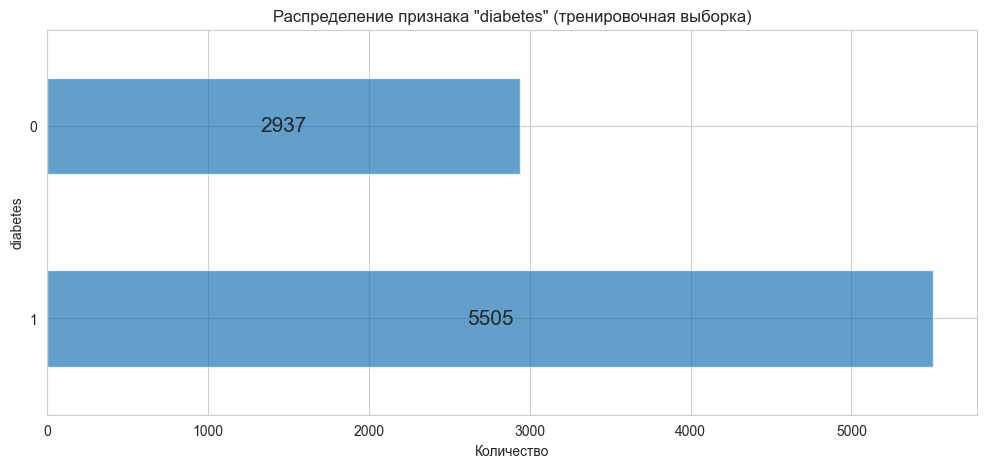

diabetes
0    34.79%
1    65.21%
Name: proportion, dtype: object


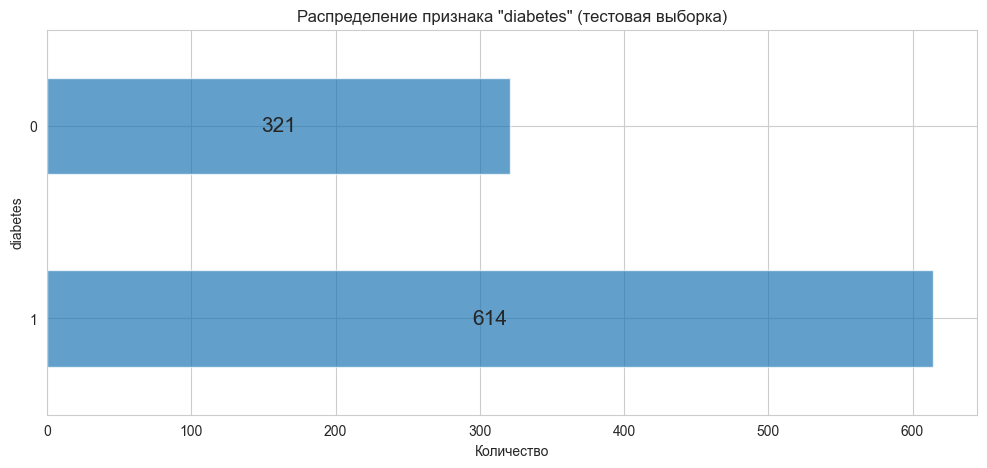

diabetes
0    34.33%
1    65.67%
Name: proportion, dtype: object


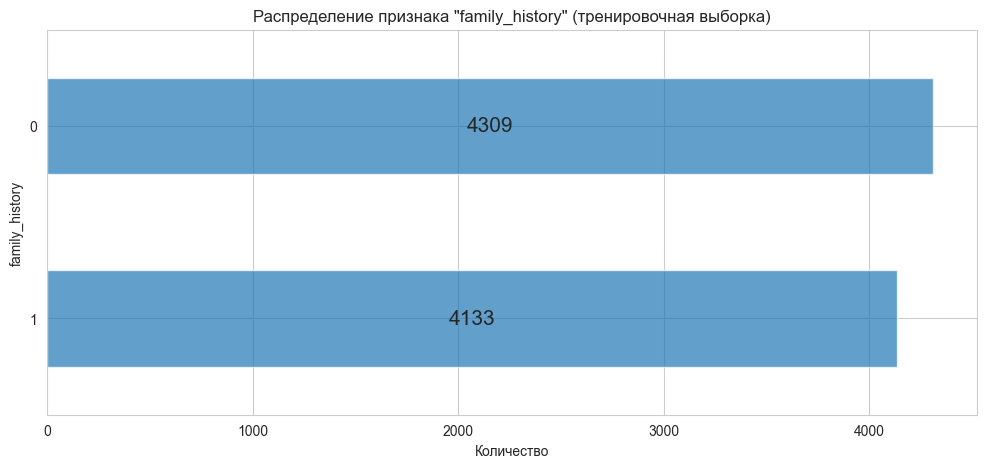

family_history
0    51.04%
1    48.96%
Name: proportion, dtype: object


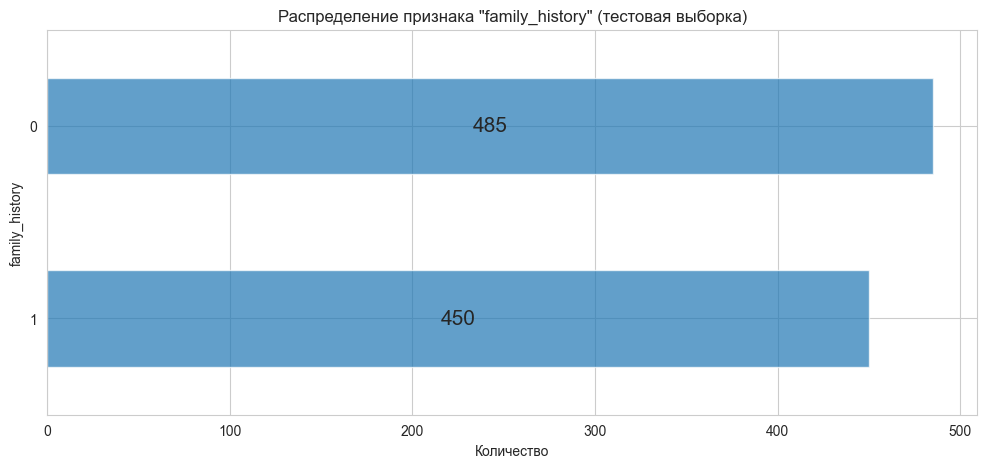

family_history
0    51.87%
1    48.13%
Name: proportion, dtype: object


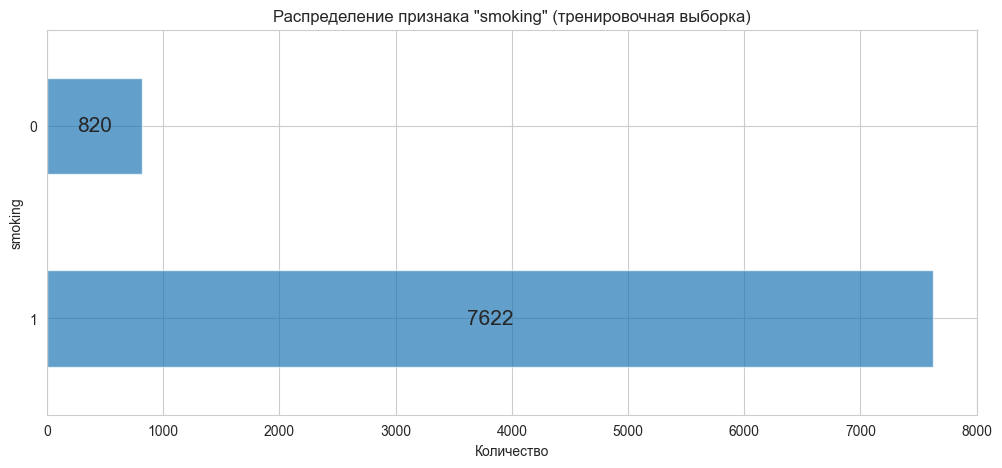

smoking
0     9.71%
1    90.29%
Name: proportion, dtype: object


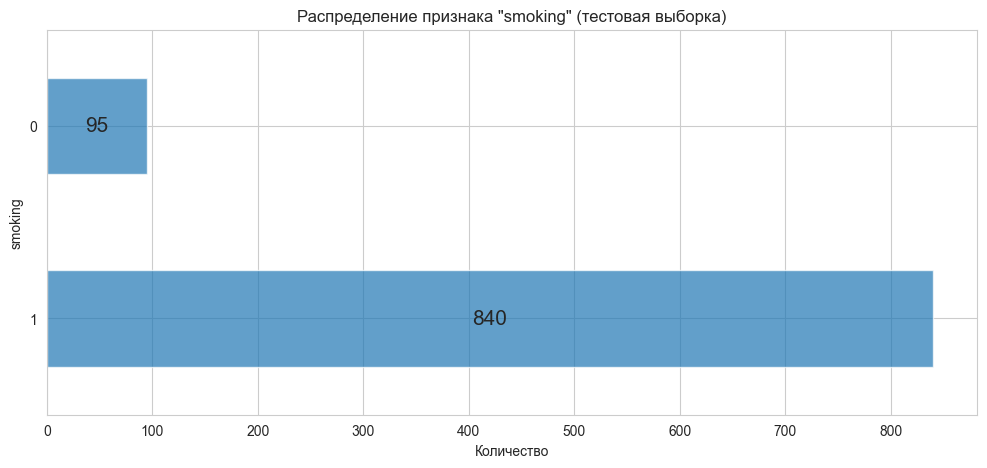

smoking
0    10.16%
1    89.84%
Name: proportion, dtype: object


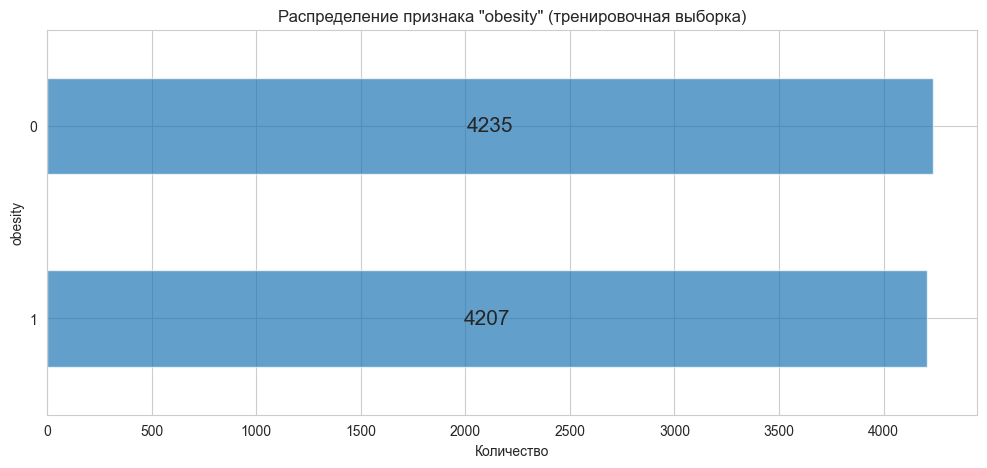

obesity
0    50.17%
1    49.83%
Name: proportion, dtype: object


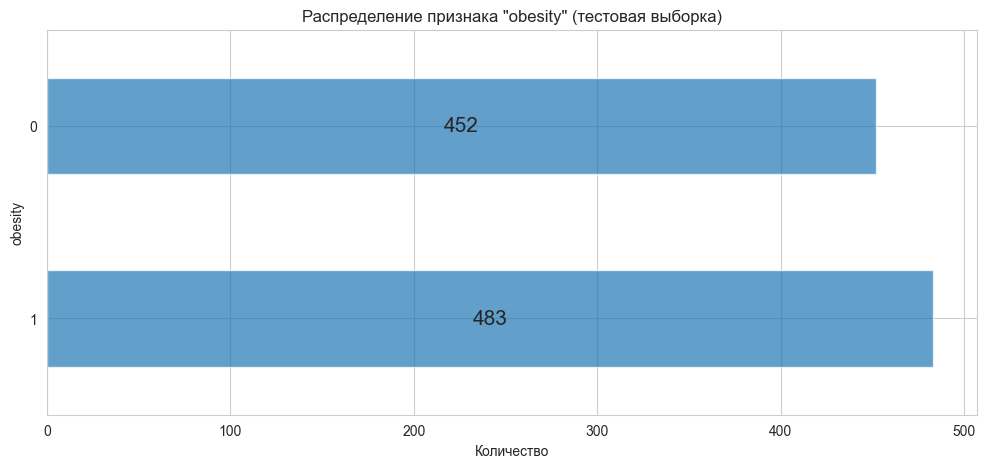

obesity
0    48.34%
1    51.66%
Name: proportion, dtype: object


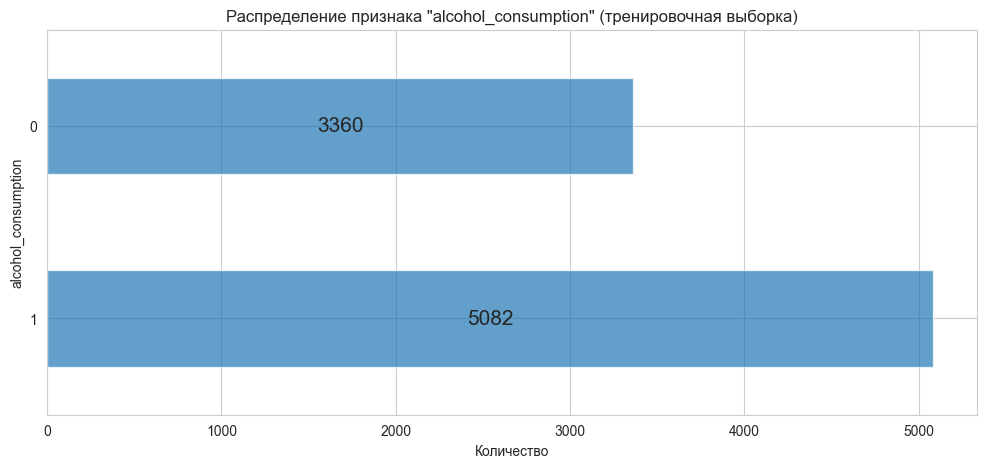

alcohol_consumption
0    39.80%
1    60.20%
Name: proportion, dtype: object


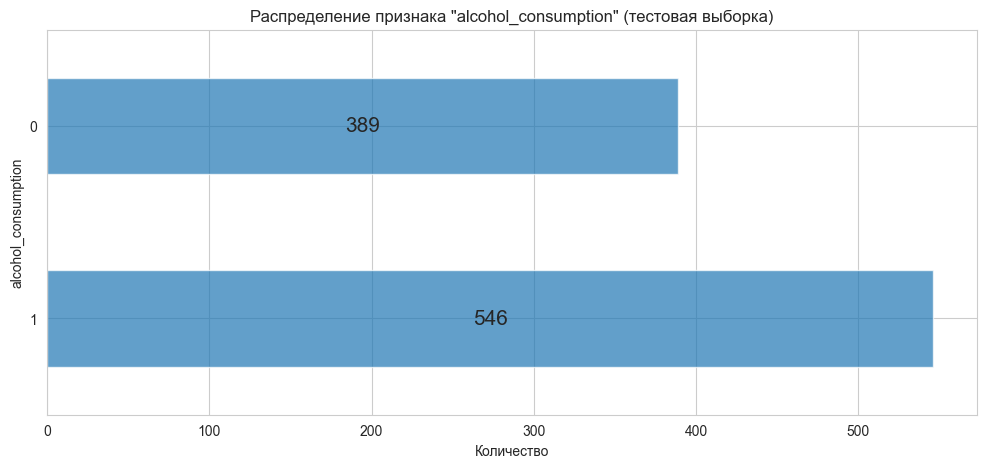

alcohol_consumption
0    41.60%
1    58.40%
Name: proportion, dtype: object


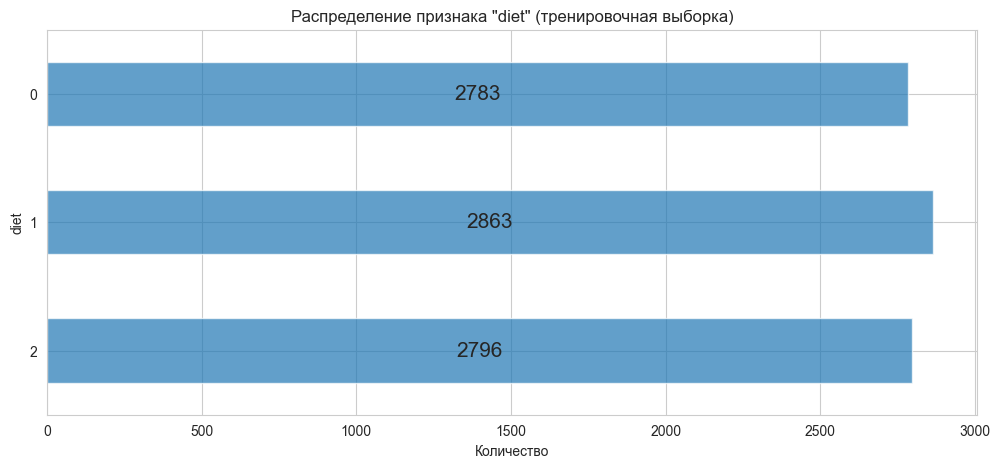

diet
0    32.97%
1    33.91%
2    33.12%
Name: proportion, dtype: object


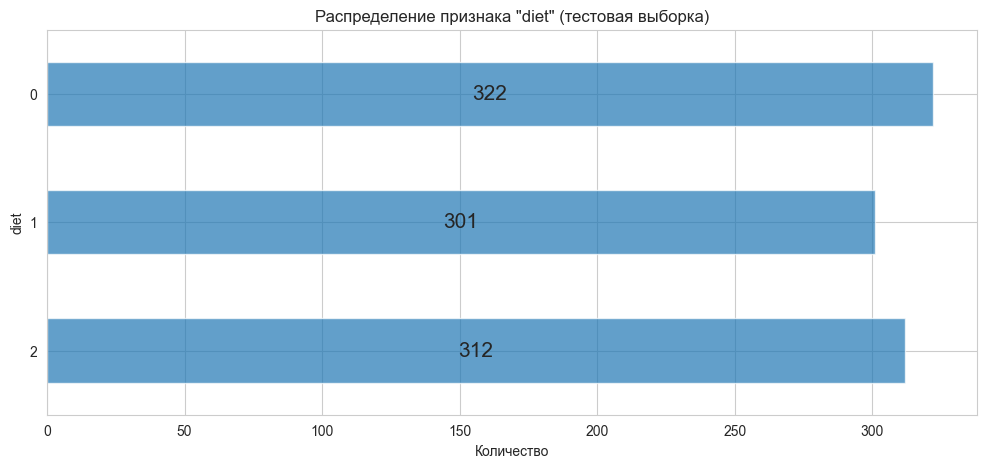

diet
0    34.44%
1    32.19%
2    33.37%
Name: proportion, dtype: object


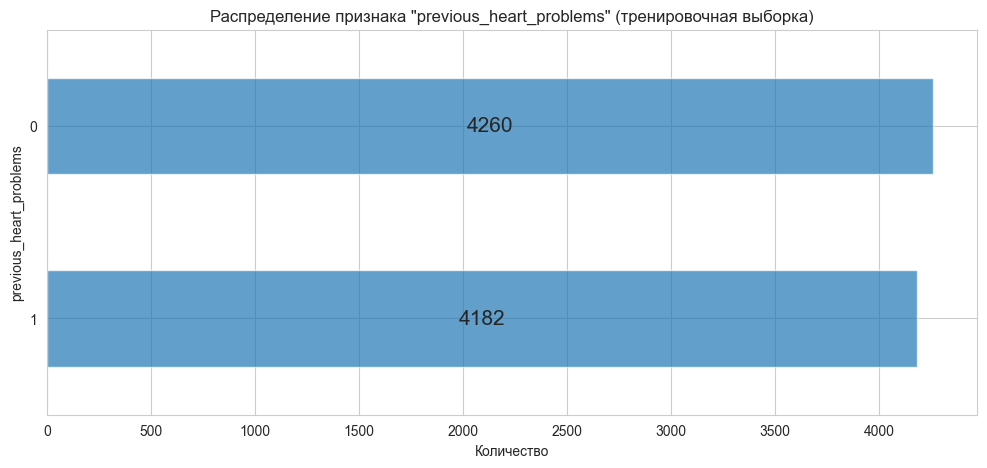

previous_heart_problems
0    50.46%
1    49.54%
Name: proportion, dtype: object


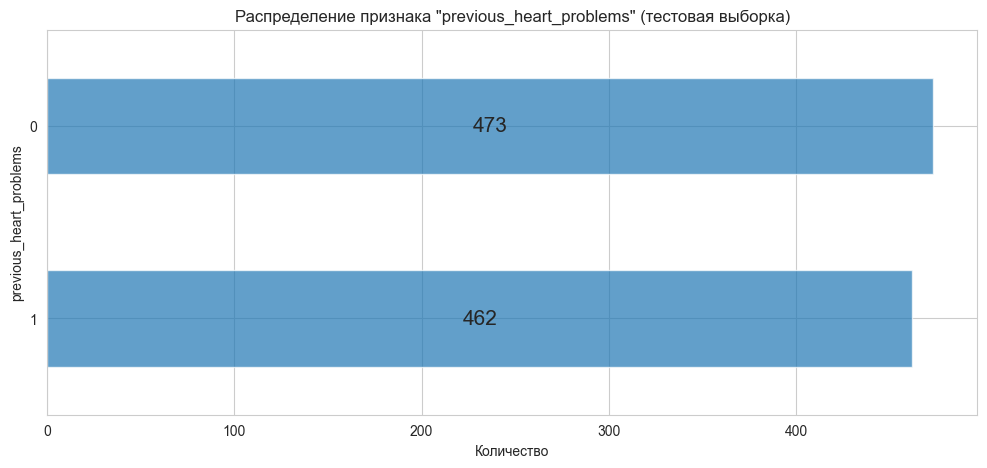

previous_heart_problems
0    50.59%
1    49.41%
Name: proportion, dtype: object


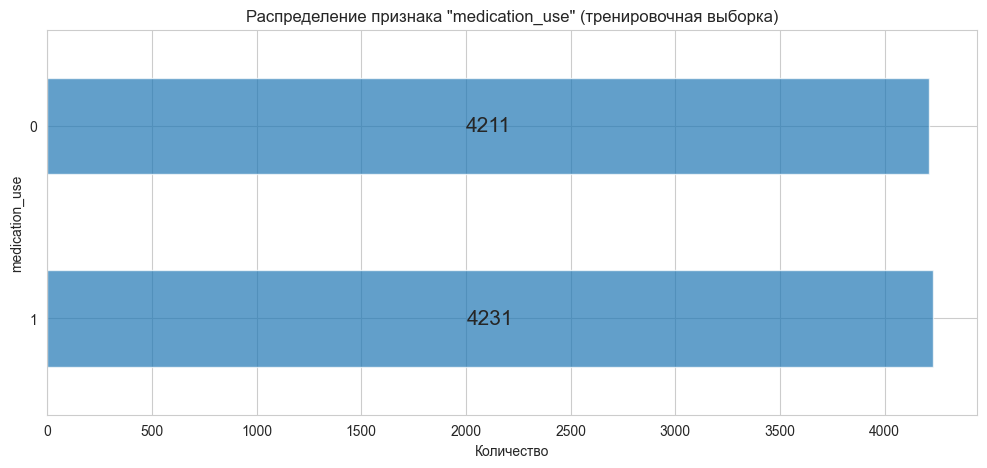

medication_use
0    49.88%
1    50.12%
Name: proportion, dtype: object


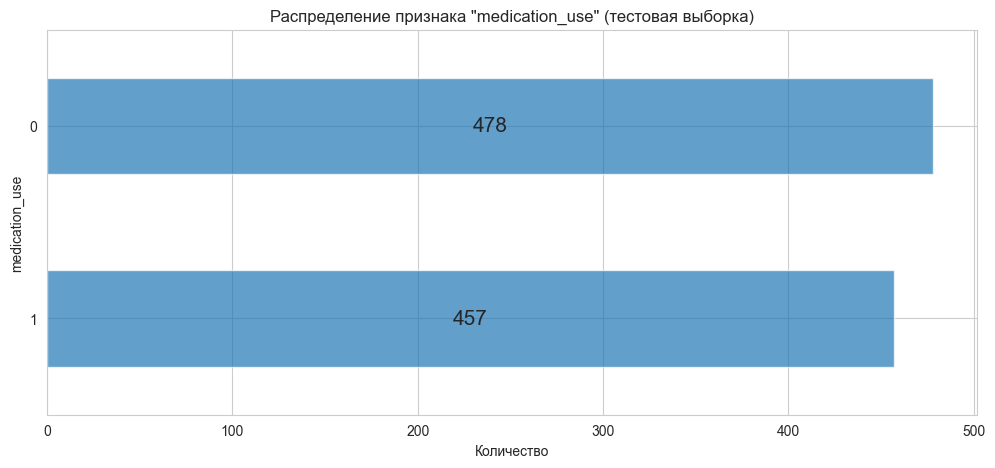

medication_use
0    51.12%
1    48.88%
Name: proportion, dtype: object


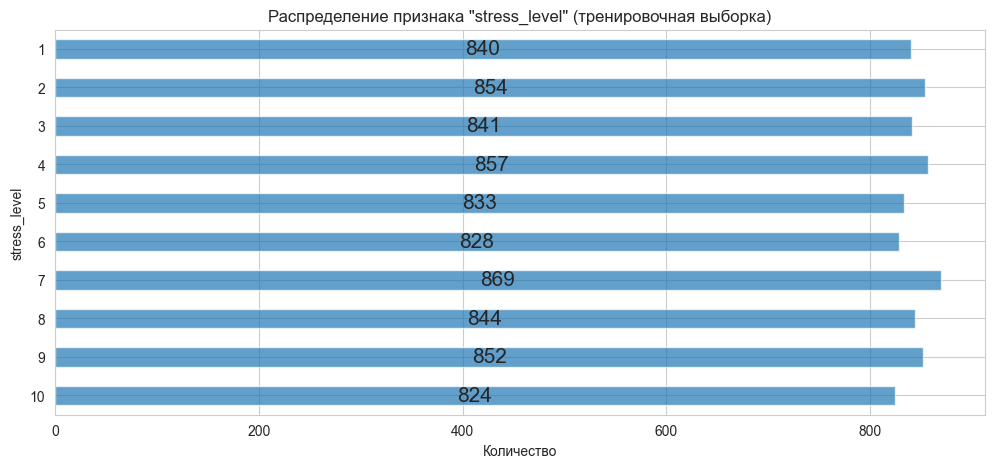

stress_level
1      9.95%
2     10.12%
3      9.96%
4     10.15%
5      9.87%
6      9.81%
7     10.29%
8     10.00%
9     10.09%
10     9.76%
Name: proportion, dtype: object


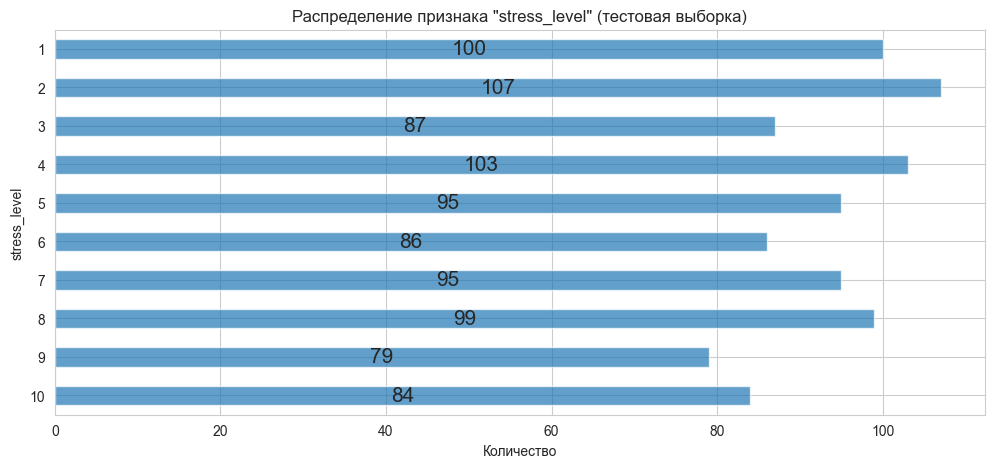

stress_level
1     10.70%
2     11.44%
3      9.30%
4     11.02%
5     10.16%
6      9.20%
7     10.16%
8     10.59%
9      8.45%
10     8.98%
Name: proportion, dtype: object


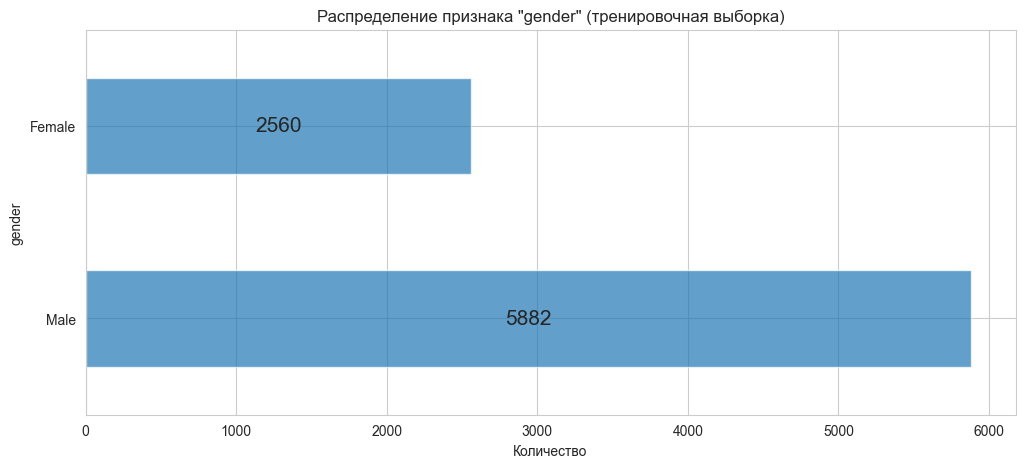

gender
Female    30.32%
Male      69.68%
Name: proportion, dtype: object


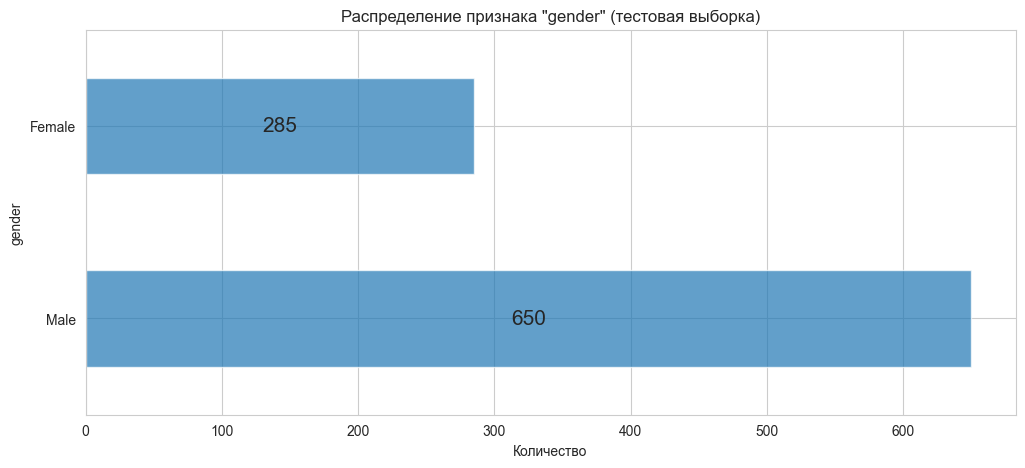

gender
Female    30.48%
Male      69.52%
Name: proportion, dtype: object


In [26]:
cat_col_names = ['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'diet', 'previous_heart_problems', 'medication_use', 
                 'stress_level', 'gender', 'heart_attack_risk_(binary)']
for i in cat_col_names[:-1]:
    categoriсal_plot(
        df_train[i], 
        f'Распределение признака "{i}" (тренировочная выборка)', 
        f'{i}')
    categoriсal_plot(
        df_test[i], 
        f'Распределение признака "{i}" (тестовая выборка)', 
        f'{i}')

Здесь тоже значения тренировочной и тестовой выборки очень близки.

Посмотрим на распределение целевого признака.

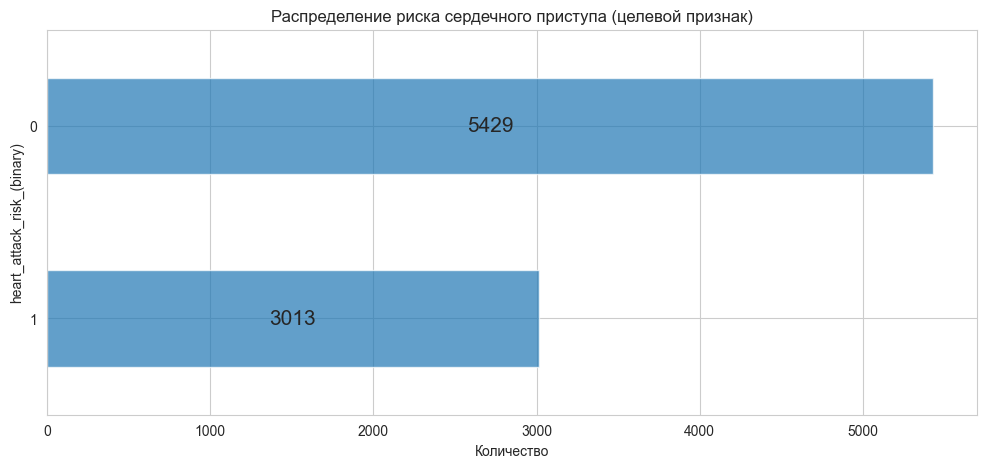

heart_attack_risk_(binary)
0    64.31%
1    35.69%
Name: proportion, dtype: object


In [27]:
categoriсal_plot(
        df_train['heart_attack_risk_(binary)'], 
        'Распределение риска сердечного приступа (целевой признак)', 
        'heart_attack_risk_(binary)')

Есть дисбаланс классов (доля значений с наличием риска сердечного приступа почти в два раза меньше, чем с отсутствием риска сердечного приступа). Чтобы это учесть, можно будет воспользоваться сэмплированием или использовать class_weight. А для оценки качества модели можно использовать независящую от дисбаланса метрику ROC-AUC, которая показывает зависимость TPR (доли верно классифицированных объектов класса 1) и FPR (доля неверно классифицированных объектов класса 0).

### 3.3. Корреляционный анализ

Построим матрицу корреляции $\phi_K$.

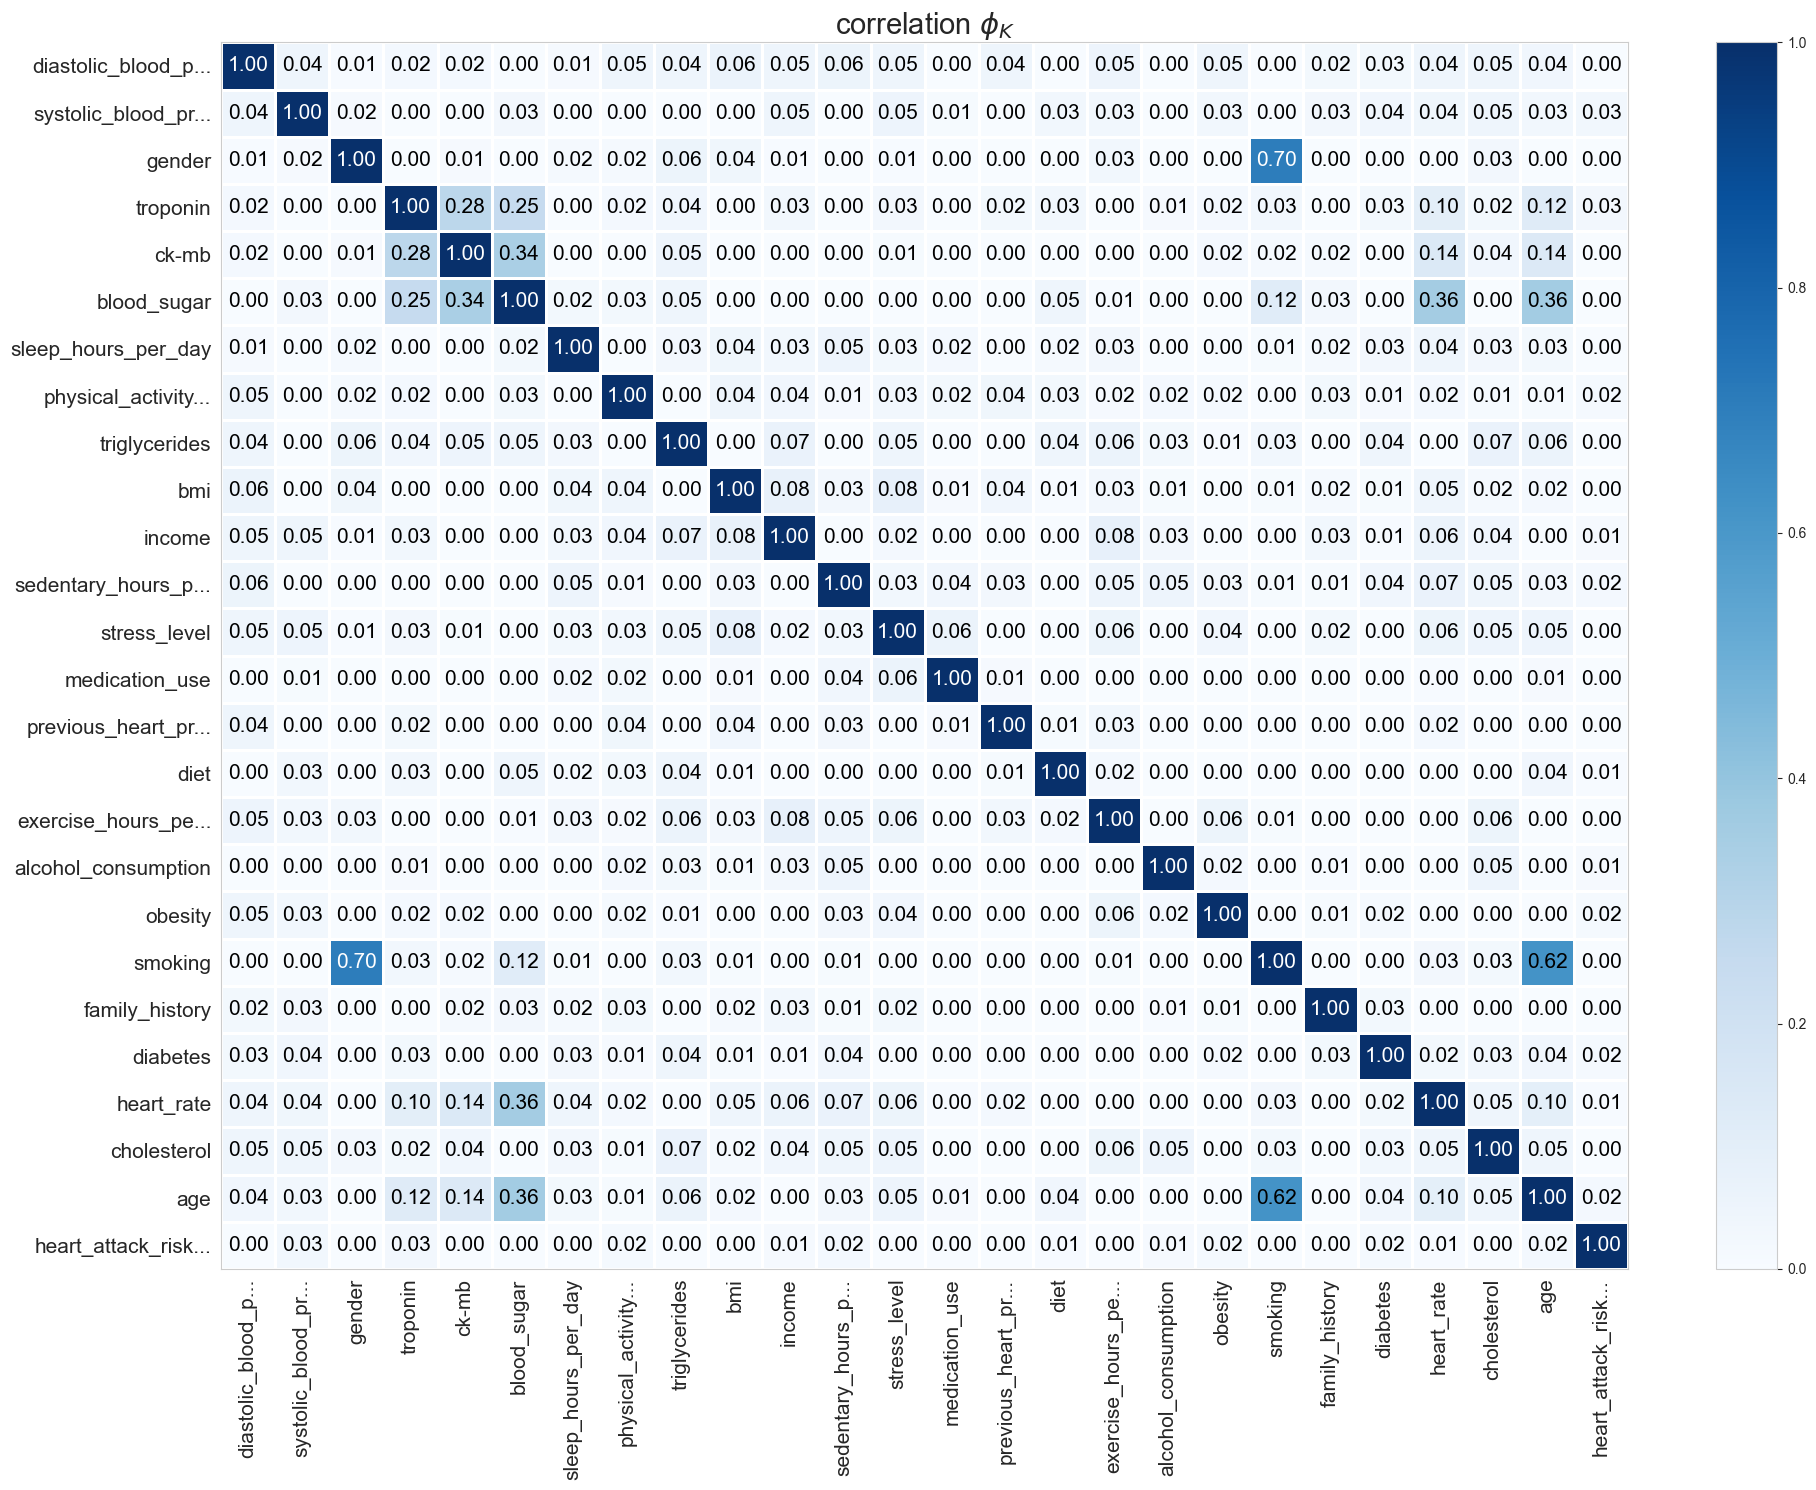

In [28]:
interval_cols = ['age', 'cholesterol', 'heart_rate', 'exercise_hours_per_week', 'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides', \
'blood_sugar', 'ck-mb', 'troponin', 'systolic_blood_pressure', 'diastolic_blood_pressure']
phik_overview = df_train.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels = phik_overview.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20,15)
)

Судя по этим данным у таргета практически отсутствуют корреляционные связи с любым из признаков. Что очень странно.

Мультиколинеарности между входными признаками не наблюдается.

Посмотрим, как распределены признаки в зависимости от значения таргета.

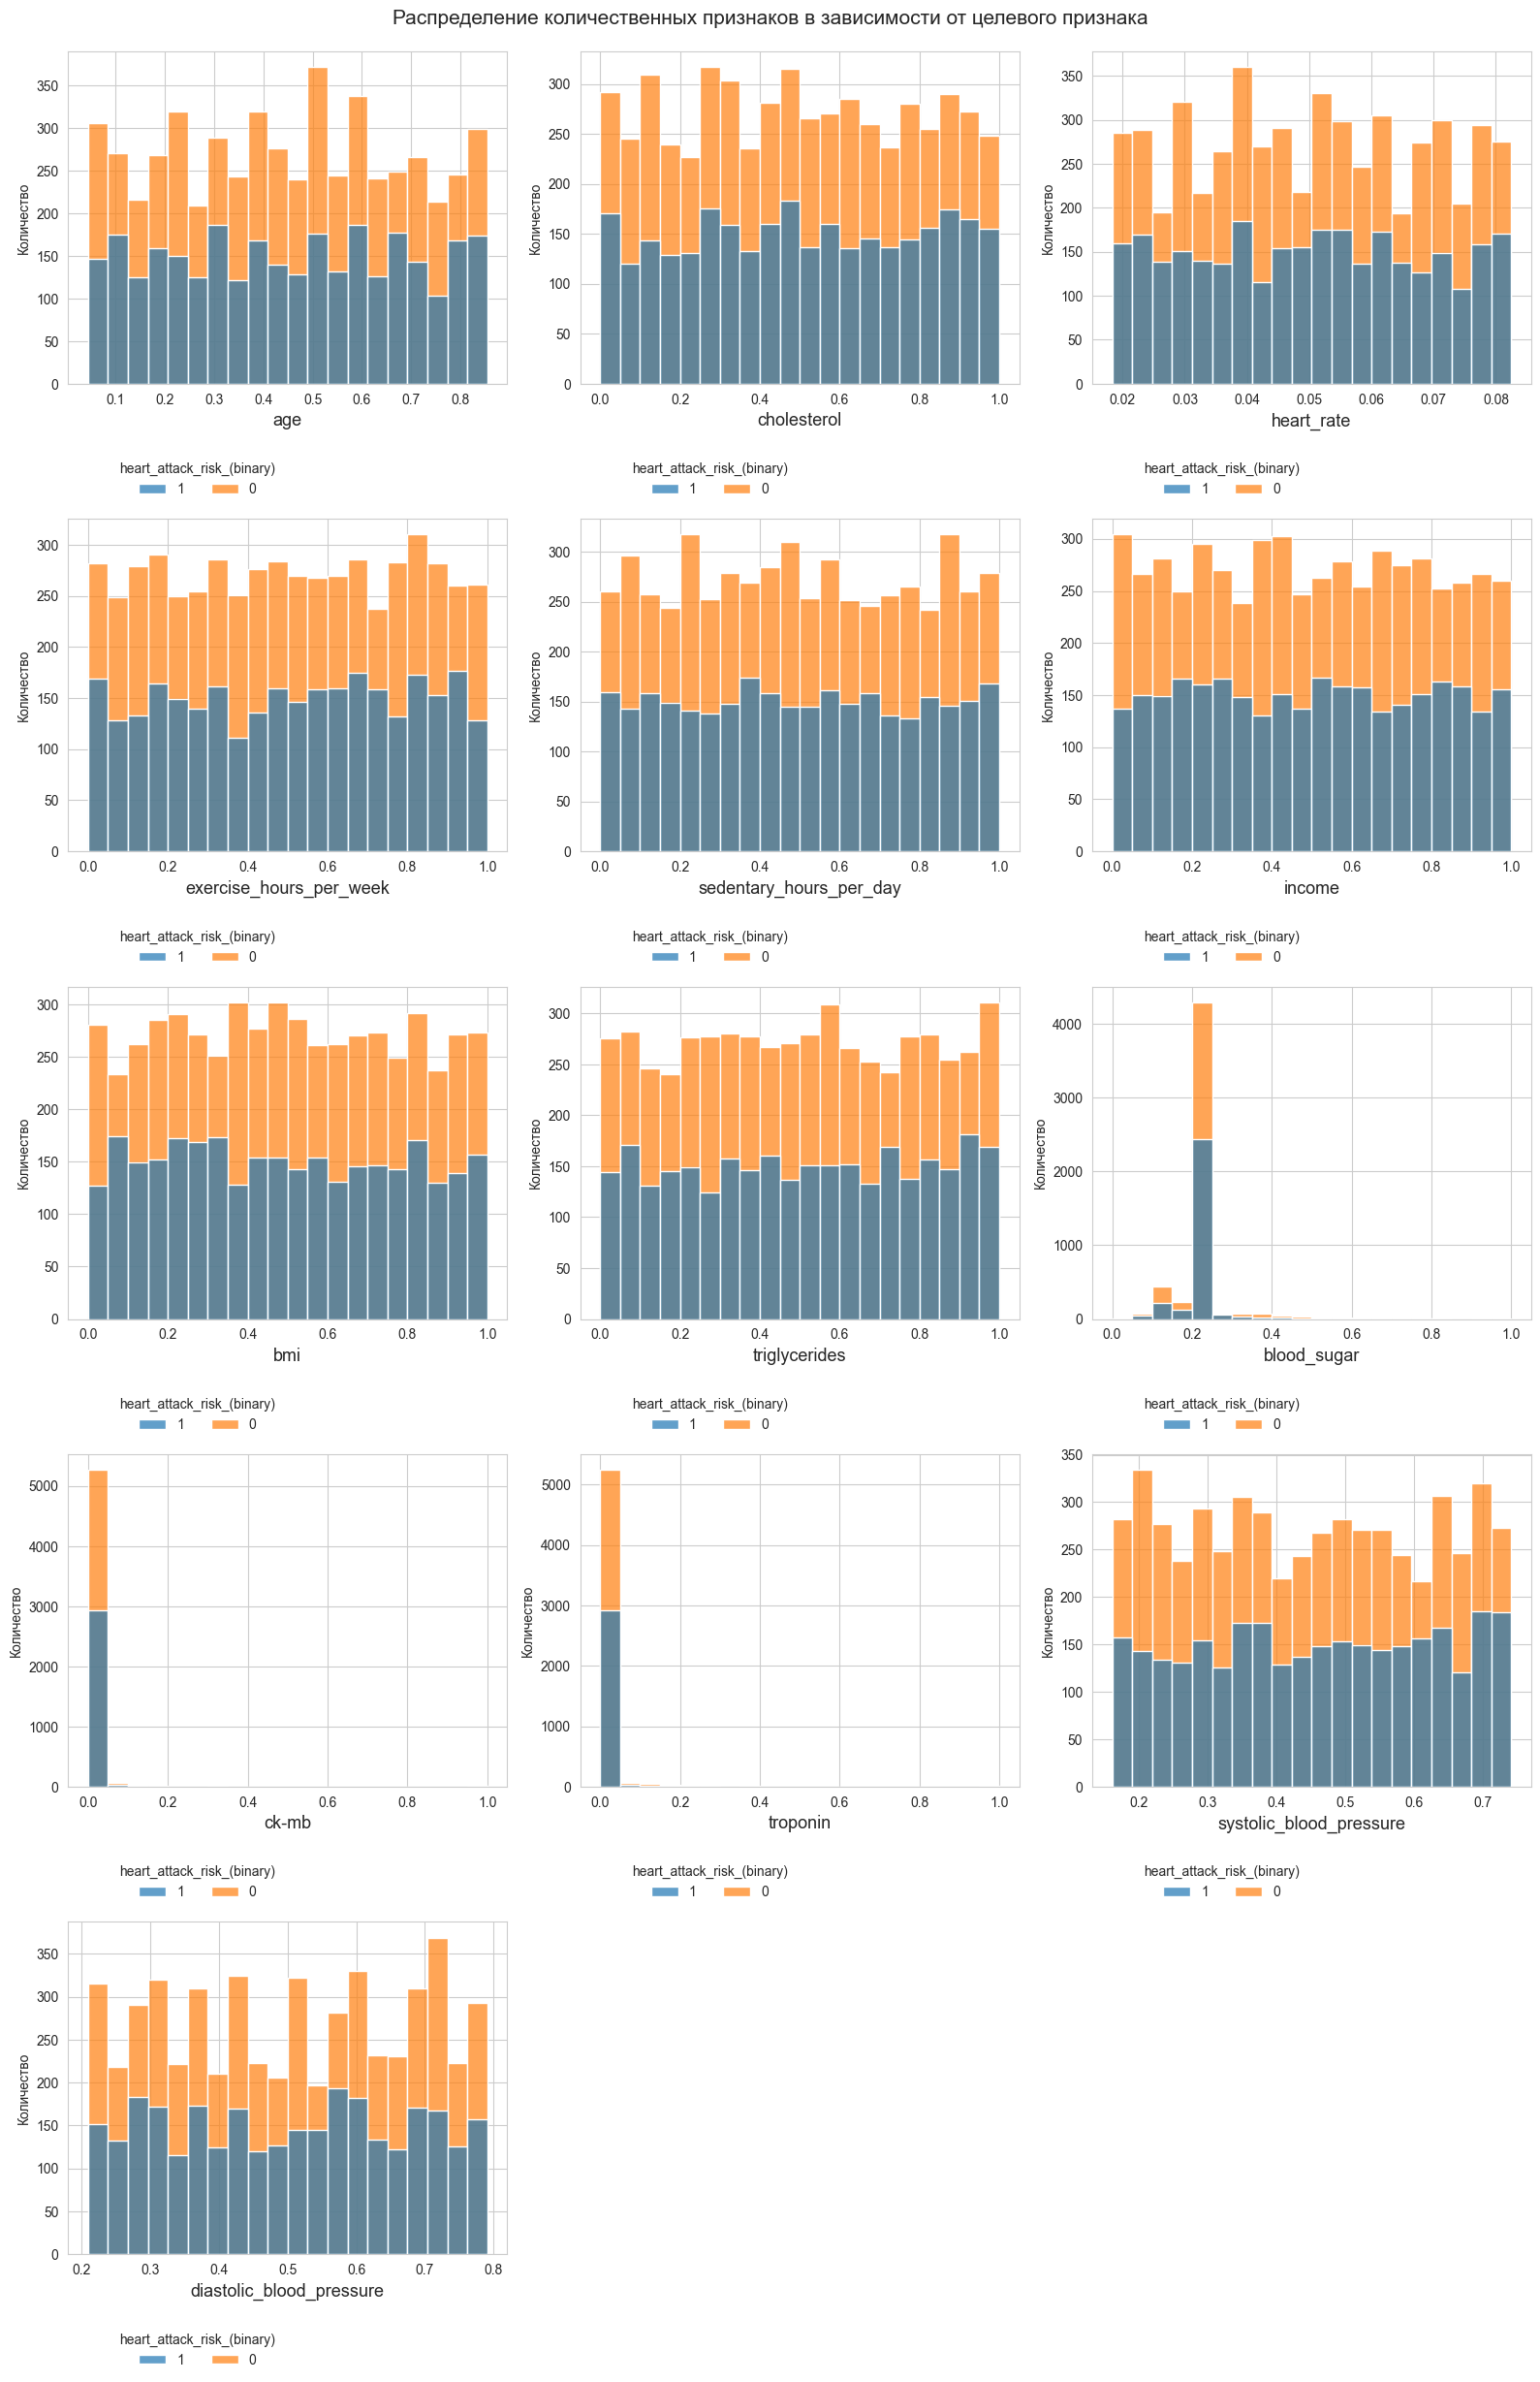

In [29]:
plt.figure(figsize=(16, 25))
for i, feature in enumerate(interval_cols, 1):
    plt.subplot(5, 3, i)
    ax=sns.histplot(data=df_train, x=feature, bins=20, hue='heart_attack_risk_(binary)', hue_order=[1, 0], alpha=0.7)
    plt.xlabel(feature, fontsize=13)
    plt.ylabel('Количество')
    sns.move_legend(ax, "upper right", bbox_to_anchor=(0.5, -0.2), ncol=2, frameon=False)

plt.suptitle('Распределение количественных признаков в зависимости от целевого признака\n\n', 
             fontsize=15)    
plt.tight_layout()    
plt.show()

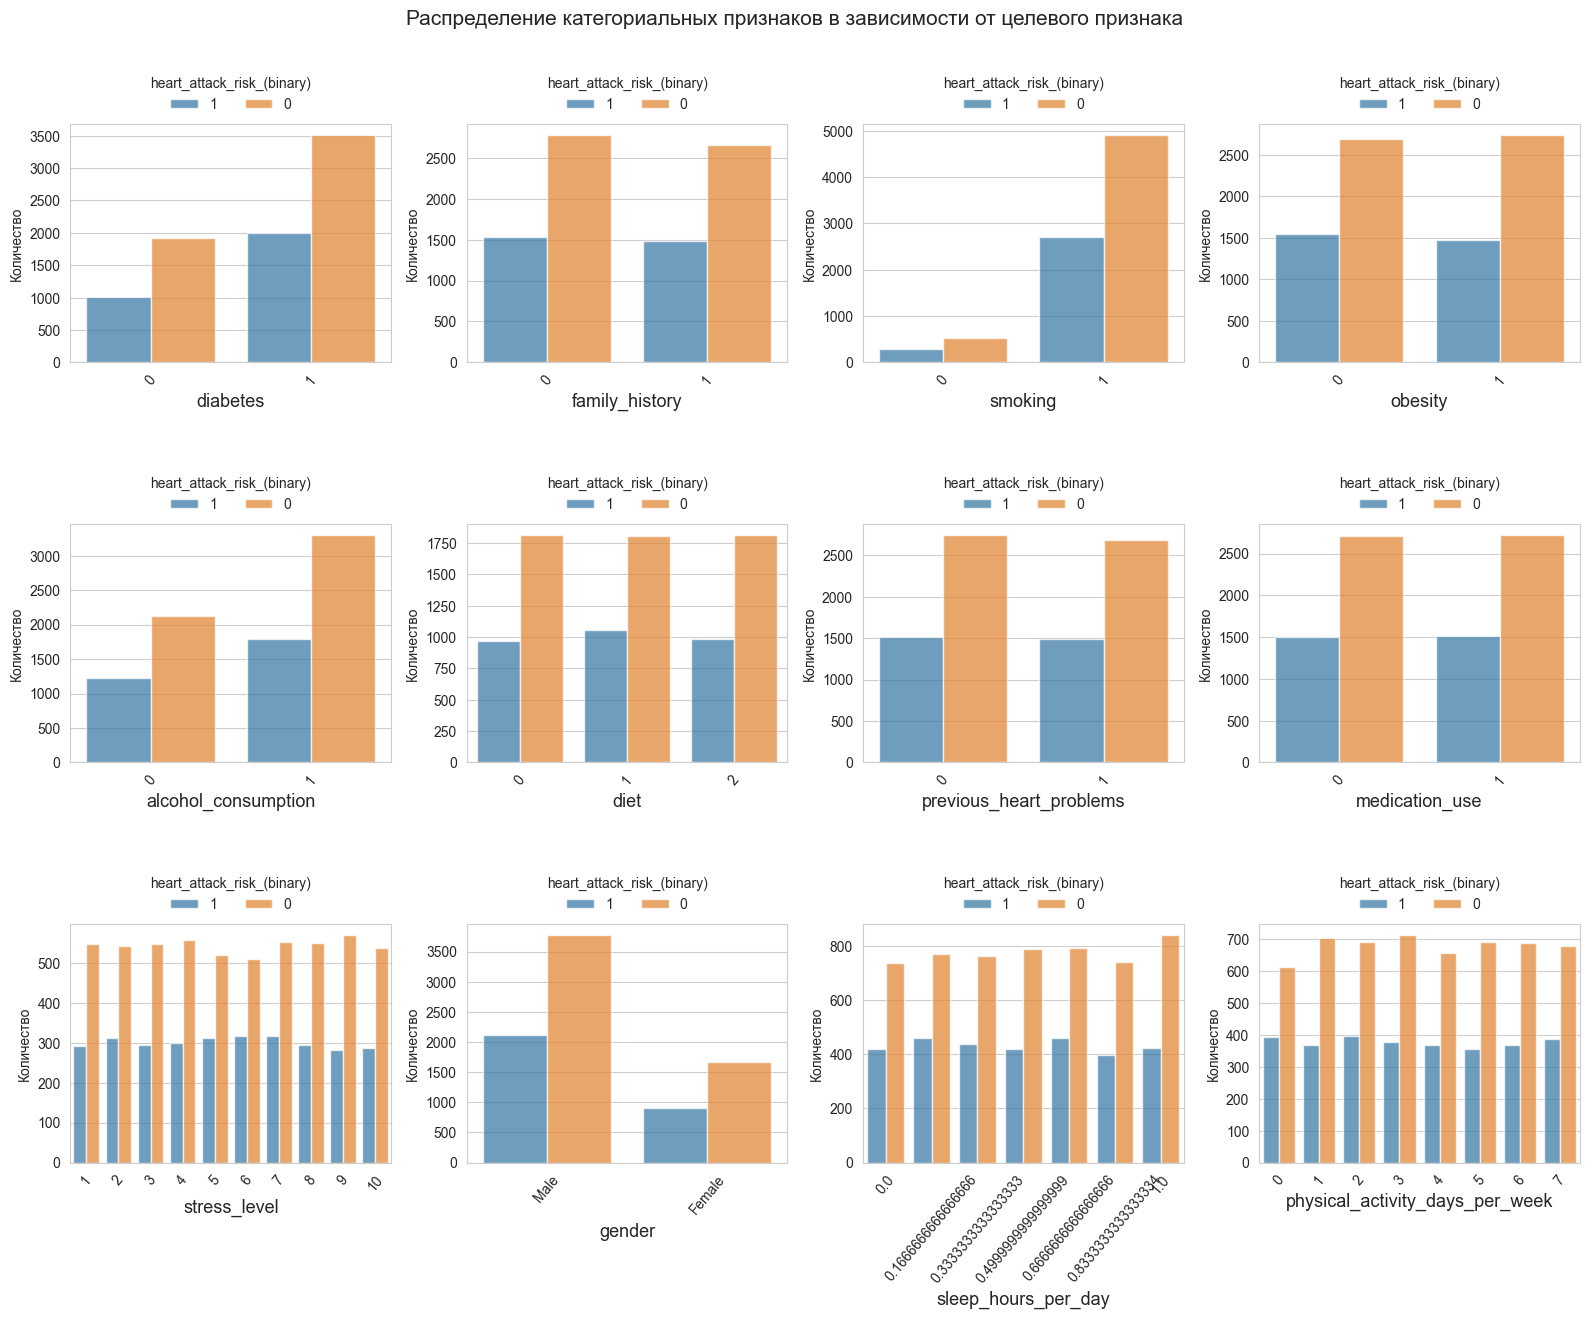

In [30]:
cat_cols = ['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'diet', 'previous_heart_problems', 'medication_use', 
                 'stress_level', 'gender', 'sleep_hours_per_day', 'physical_activity_days_per_week']
plt.figure(figsize=(16, 16))
for i, feature in enumerate(cat_cols, 1):
    plt.subplot(4, 4, i)
    ax=sns.countplot(data=df_train, x=feature, hue='heart_attack_risk_(binary)', hue_order=[1, 0], alpha=0.7)
    plt.xlabel(feature, fontsize=13)
    plt.ylabel('Количество')
    plt.xticks(rotation=50)
    sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, 1), ncol=2, frameon=False)

plt.suptitle('Распределение категориальных признаков в зависимости от целевого признака\n\n', 
             fontsize=15)    
plt.tight_layout()  
plt.show()

Как и в случае с корреляционным анализом, не видно какой-то зависимости между таргетом и количественными признаками. По категориальным признакам: значений с классом 1 немного больше у пациентов с диабетом, курящих, употребляющих алкоголь и мужчин, но, при этом, и общее количество записей с этими значениями выше (т.е. пациентов с диабетом больше, чем без диабета; мужчин больше, чем женщин и т.д.).

### Вывод:

Мы провели исследовательский анализ данных, в ходе которого изучили количественные и категориальные признаки. Можно выделить следующее:

* Значения тренировочных и тестовых данных очень близки.
* Практически у всех признаков (`'age'`, `'cholesterol'`, `'heart_rate'`, `'exercise_hours_per_week'`, `'sedentary_hours_per_day'`, `'income'`, `'bmi'`, `'triglycerides'`, `'sleep_hours_per_day'`, `'systolic_blood_pressure'`, `'diastolic_blood_pressure'`)  распределение равномерное, выбросы отсутствуют. Так как значения уже нормализованы, они лежат в диапазоне от 0 до 1. Но только у признака `'heart_rate'` значения в 10 раз меньше и распределены в диапазоне от 0.02 до 0.08.
* Данные у дискретных признаков `'physical_activity_days_per_week'` и `'sleep_hours_per_day'` также распределены равномерно, но только у 
`'sleep_hours_per_day'` значения нормализованы и лежат в диапазоне от 0 до 1, а у `'physical_activity_days_per_week'` значения не нормализованы и лежат в диапазоне от 0 до 7.
* Признаки `'ck-mb'`  и `'troponin'` - это показатели, повышенный уровень которых является следствием инфаркта, а не фактором, увеличивающим риск - утечка целевого признака. 
* Больше половины значений разницы между верхним(систолическим) и нижним(диастолическим) давлением отрицательные, чего быть не должно. Возможно, значения верхнего(систолического) и нижнего(диастолического) давления были переставлены местами.
* Есть дисбаланс классов (доля значений с наличием риска сердечного приступа почти в два раза меньше, чем с отсутствием риска сердечного приступа).

Также был проведен корреляционный анализ, который показал, что у таргета практически отсутсвуют корреляционные связи с любым из признаков.

Мультиколлинеарности между входными признаками не обнаружено.

Не видно какой-либо зависимости между таргетом и количественными признаками. По категориальным признакам: значений с классом 1 немного больше у пациентов с диабетом, курящих, употребляющих алкоголь и мужчин, но, при этом, и общее количество записей с этими значениями выше (т.е. пациентов с диабетом больше, чем без диабета; мужчин больше, чем женщин и т.д.).

## 4. Построение модели

### 4.1. Первая модель

Для начала закодируем признак `'gender'` (1 - мужской пол, 0 - женский), приведем `'heart_rate'` к диапазону от 0 до 1, удалим признаки `'ck-mb'`  и `'troponin'` (утечка целевого признака), а затем разобьем данные на тренировочную и тестовую выборки с учетом стратификации по целевому признаку, так как ранее мы выявили дисбаланс классов по нему.

In [31]:
df_train['gender'] = df_train['gender'].apply(lambda x: 1 if x == 'Male' else 0)
df_train['heart_rate'] = df_train['heart_rate'] * 10
df_train = df_train.drop(['ck-mb', 'troponin'], axis=1)
df_train.head()

,heart_attack_risk_(binary),age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,gender,systolic_blood_pressure,diastolic_blood_pressure
id,,,,,,,,,,,,,,,,,,,,,,,,
2664,0,0.359551,0.732143,0.742438,1,1,1,1,1,0.535505,1,1,0,8,0.225704,0.105948,0.459176,0.979221,3,0.333333,0.227018,1,0.212903,0.709302
9287,0,0.202247,0.325000,0.476627,1,1,0,0,1,0.068690,2,1,0,9,0.289923,0.164217,0.117053,0.515584,3,0.833333,0.150198,0,0.412903,0.569767
5379,0,0.606742,0.860714,0.559120,1,0,1,1,1,0.944001,2,1,1,6,0.550133,0.598745,0.373574,0.012987,2,1.000000,0.227018,0,0.238710,0.220930
8222,1,0.730337,0.007143,0.531622,0,0,1,0,1,0.697023,0,0,1,3,0.330962,0.077605,0.049735,0.131169,0,0.333333,0.227018,0,0.348387,0.267442
4047,1,0.775281,0.757143,0.219982,0,0,1,0,1,0.412878,1,0,0,8,0.524600,0.341960,0.830405,0.070130,5,1.000000,0.227018,1,0.619355,0.441860


In [32]:
X = df_train.drop('heart_attack_risk_(binary)', axis=1)
y = df_train['heart_attack_risk_(binary)']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)
print('Размер X_train:', X_train.shape)
print('Размер X_test:', X_test.shape)
print('Размер y_train:', y_train.shape)
print('Размер y_test:', y_test.shape)

Размер X_train: (6331, 23)
Размер X_test: (2111, 23)
Размер y_train: (6331,)
Размер y_test: (2111,)


Будем обучать две модели: CatBoostClassifier() и RandomForestClassifier()

In [33]:
# создаём словари с гиперпараметрами для каждой модели

params_cb = {
        'iterations': [500, 1000],
        'depth': [10, 12]
    }

params_rf = {
        'n_estimators': [100, 200],
        'max_depth': range(10, 15) 
    }

In [34]:
cb = CatBoostClassifier(learning_rate=0.1, random_state=RANDOM_STATE)

grid_search_cb = GridSearchCV(
    cb, 
    params_cb, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search_cb.fit(X_train, y_train, verbose=False)

print('Лучшая модель и её параметры:\n\n', grid_search_cb.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', round(grid_search_cb.best_score_, 4))

Лучшая модель и её параметры:

Метрика лучшей модели на кросс-валидации: 0.5717


In [35]:
(pd.DataFrame(grid_search_cb.cv_results_).sort_values(by='rank_test_score')
    [['rank_test_score', 'mean_test_score', 'params', 'mean_fit_time']])

,rank_test_score,mean_test_score,params,mean_fit_time
1,1,0.571709,"{'depth': 10, 'iterations': 1000}",40.866299
0,2,0.570677,"{'depth': 10, 'iterations': 500}",17.484293
2,3,0.569757,"{'depth': 12, 'iterations': 500}",51.374981
3,4,0.566584,"{'depth': 12, 'iterations': 1000}",82.280390


Метрика ROC-AUC на тестовой выборке: 0.5767
              precision    recall  f1-score   support

           0       0.66      0.90      0.76      1358
           1       0.49      0.18      0.27       753

    accuracy                           0.64      2111
   macro avg       0.58      0.54      0.52      2111
weighted avg       0.60      0.64      0.59      2111



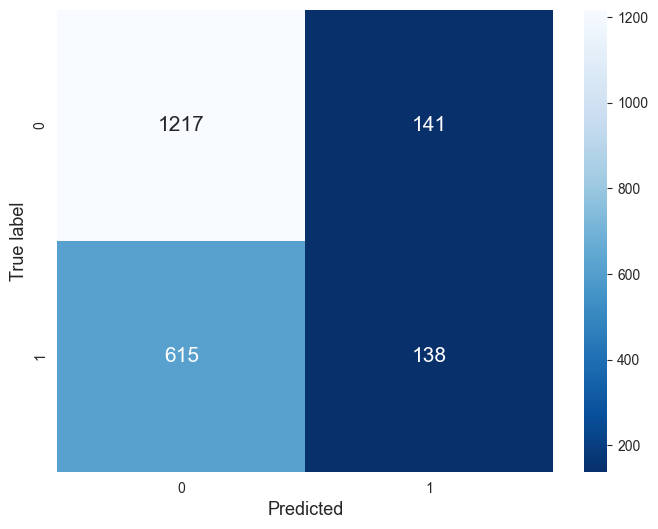

In [36]:
# проверим работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных
y_pred_cb = grid_search_cb.predict_proba(X_test)[:, 1]
roc_auc_cb = round(roc_auc_score(y_test, y_pred_cb), 4)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_cb:.4f}')

y_predict_cb = grid_search_cb.predict(X_test)
f1_cb = round(f1_score(y_test, y_predict_cb), 4)
print(classification_report(y_test, y_predict_cb))

cm_cb = confusion_matrix(y_test, y_predict_cb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cb, annot=True, fmt='d', cmap='Blues_r', annot_kws={'size': 15})
plt.ylabel('True label', fontsize=13)
plt.xlabel('Predicted', fontsize=13)
plt.show()

* TP = 138: в 138 случаях модель правильно отнесла наличие риска сердечного приступа к категории 1;
* FP = 141: в 141 случаях модель неправильно отнесла отсутствие риска сердечного приступа к категории '1' (ошибка 1го рода);
* FN = 615: в 615 случаях модель неправильно отнесла наличие риска сердечного приступа к категории ' 0' (ошибка 2го рода);
* TN = 1217: в 1217 случаях модель правильно отнесла отсутствие риска сердечного приступа к категории '0'.

Модель очень плохо предсказывает класс 1, в отличие от класса 0. Очень много ошибок 2го рода, что для нас критично.

In [37]:
rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')

grid_search_rf = GridSearchCV(
    rf, 
    params_rf, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search_rf.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search_rf.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', round(grid_search_rf.best_score_, 4))

Лучшая модель и её параметры:

 RandomForestClassifier(class_weight='balanced', max_depth=13, n_estimators=200,
                       random_state=42)
Метрика лучшей модели на кросс-валидации: 0.5648


In [38]:
(pd.DataFrame(grid_search_rf.cv_results_).sort_values(by='rank_test_score')
    [['rank_test_score', 'mean_test_score', 'params', 'mean_fit_time']])

,rank_test_score,mean_test_score,params,mean_fit_time
7,1,0.564780,"{'max_depth': 13, 'n_estimators': 200}",1.876057
6,2,0.563745,"{'max_depth': 13, 'n_estimators': 100}",0.980285
5,3,0.560840,"{'max_depth': 12, 'n_estimators': 200}",1.790615
9,4,0.558429,"{'max_depth': 14, 'n_estimators': 200}",1.422369
4,5,0.556978,"{'max_depth': 12, 'n_estimators': 100}",0.952559
8,6,0.556448,"{'max_depth': 14, 'n_estimators': 100}",1.004344
3,7,0.552996,"{'max_depth': 11, 'n_estimators': 200}",1.600130
2,8,0.550311,"{'max_depth': 11, 'n_estimators': 100}",0.873835
1,9,0.547264,"{'max_depth': 10, 'n_estimators': 200}",1.467026
0,10,0.545021,"{'max_depth': 10, 'n_estimators': 100}",0.684622


Метрика ROC-AUC на тестовой выборке: 0.5684
              precision    recall  f1-score   support

           0       0.66      0.94      0.78      1358
           1       0.58      0.14      0.22       753

    accuracy                           0.66      2111
   macro avg       0.62      0.54      0.50      2111
weighted avg       0.63      0.66      0.58      2111



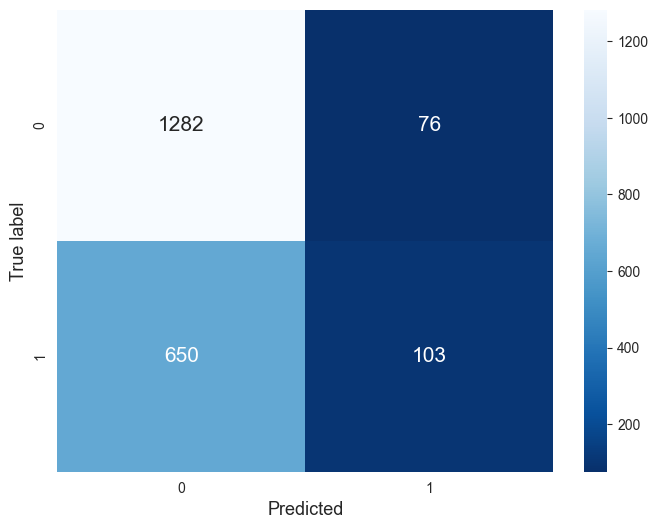

In [39]:
# проверим работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных
y_pred_rf = grid_search_rf.predict_proba(X_test)[:, 1]
roc_auc_rf = round(roc_auc_score(y_test, y_pred_rf), 4)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_rf:.4f}')

y_predict_rf = grid_search_rf.predict(X_test)
f1_rf = round(f1_score(y_test, y_predict_rf), 4)
print(classification_report(y_test, y_predict_rf))

cm_rf = confusion_matrix(y_test, y_predict_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues_r', annot_kws={'size': 15})
plt.ylabel('True label', fontsize=13)
plt.xlabel('Predicted', fontsize=13)
plt.show()

* TP = 103: в 103 случаях модель правильно отнесла наличие риска сердечного приступа к категории 1;
* FP = 76: в 76 случаях модель неправильно отнесла отсутствие риска сердечного приступа к категории '1' (ошибка 1го рода);
* FN = 650: в 650 случаях модель неправильно отнесла наличие риска сердечного приступа к категории ' 0' (ошибка 2го рода);
* TN = 1282: в 1282 случаях модель правильно отнесла отсутствие риска сердечного приступа к категории '0'.

Модель CatBoost справилась немного лучше, чем RandomForest.

In [40]:
results = pd.DataFrame(columns=['модель', 'f1', 'roc_auc', 'TP', 'FN', 'FP'])
results.loc[0] = ['CatBoostClassifier', f1_cb, roc_auc_cb, 138, 615, 141]
results.loc[1] = ['RandomForestClassifier', f1_rf, roc_auc_rf, 103, 650, 76]
results

,модель,f1,roc_auc,TP,FN,FP
0,CatBoostClassifier,0.2674,0.5767,138,615,141
1,RandomForestClassifier,0.2210,0.5684,103,650,76


### 4.2. Вторая модель (с RandomUnderSampler)

Попробуем с помощью RandomUnderSampler убрать дисбаланс целевого признака.

In [41]:
# словари с гиперпараметрами для каждой модели
param_cb = {
        'models': [CatBoostClassifier(learning_rate=0.1, random_state=RANDOM_STATE, verbose=False)],
        'models__iterations': [500, 1000],
        'models__depth': [10, 12]
    }

param_rf = {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__n_estimators': [100, 200],
        'models__max_depth': range(10, 15) 
    }


# Создание пайплайна с RandomUnderSampler для устранения дисбаланса
pipe_final = ImbPipeline([
('sampling', RandomUnderSampler(random_state=RANDOM_STATE)),
('models', LogisticRegression())
])

In [42]:
grid_search_cb_2 = GridSearchCV(
    pipe_final, 
    param_cb, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search_cb_2.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search_cb_2.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', round(grid_search_cb_2.best_score_, 4))

Лучшая модель и её параметры:

 Pipeline(steps=[('sampling', RandomUnderSampler(random_state=42)),
                ('models',
                 <catboost.core.CatBoostClassifier object at 0x14a5b2150>)])
Метрика лучшей модели на кросс-валидации: 0.5674


In [43]:
(pd.DataFrame(grid_search_cb_2.cv_results_).sort_values(by='rank_test_score')
    [['rank_test_score', 'mean_test_score', 'params', 'mean_fit_time']])

,rank_test_score,mean_test_score,params,mean_fit_time
2,1,0.567380,"{'models': <catboost.core.CatBoostClassifier object at 0x14a5b2050>, 'models__depth': 12, 'models__iterations': 500}",51.276805
3,2,0.566784,"{'models': <catboost.core.CatBoostClassifier object at 0x14a5b2050>, 'models__depth': 12, 'models__iterations': 1000}",79.053457
0,3,0.566574,"{'models': <catboost.core.CatBoostClassifier object at 0x14a5b2050>, 'models__depth': 10, 'models__iterations': 500}",18.523610
1,4,0.562642,"{'models': <catboost.core.CatBoostClassifier object at 0x14a5b2050>, 'models__depth': 10, 'models__iterations': 1000}",38.912087


Метрика ROC-AUC на тестовой выборке: 0.5731
              precision    recall  f1-score   support

           0       0.67      0.54      0.60      1358
           1       0.39      0.53      0.45       753

    accuracy                           0.54      2111
   macro avg       0.53      0.54      0.52      2111
weighted avg       0.57      0.54      0.55      2111



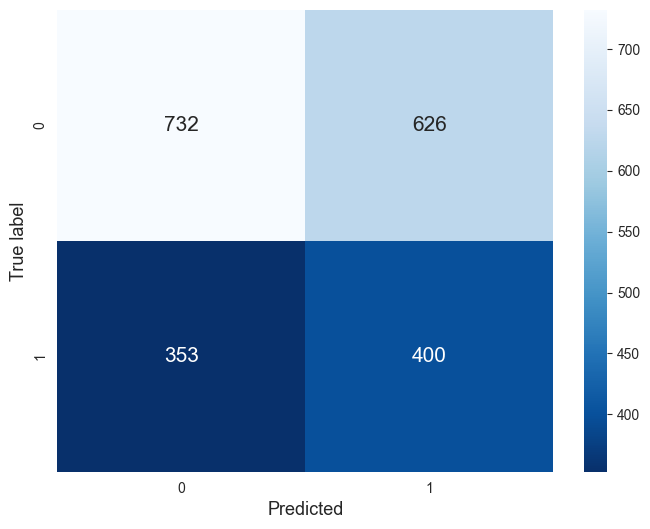

In [44]:
# проверим работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных
y_pred_cb_2 = grid_search_cb_2.predict_proba(X_test)[:, 1]
roc_auc_cb_2 = round(roc_auc_score(y_test, y_pred_cb_2), 4)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_cb_2:.4f}')

y_predict_cb_2 = grid_search_cb_2.predict(X_test)
f1_cb_2 = round(f1_score(y_test, y_predict_cb_2), 4)
print(classification_report(y_test, y_predict_cb_2))

cm_cb_2 = confusion_matrix(y_test, y_predict_cb_2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cb_2, annot=True, fmt='d', cmap='Blues_r', annot_kws={'size': 15})
plt.ylabel('True label', fontsize=13)
plt.xlabel('Predicted', fontsize=13)
plt.show()

Стало немного лучше:
* Увеличилось количество TP c 138 до 400;
* Стало меньше ошибок 2го рода (было 615, теперь 353).

Но TN уменьшилось с 1217 до 732 и стало больше ошибок 1го рода (было 141, теперь - 626). 

In [45]:
grid_search_rf_2 = GridSearchCV(
    pipe_final, 
    param_rf, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search_rf_2.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search_rf_2.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', round(grid_search_rf_2.best_score_, 4))

Лучшая модель и её параметры:

 Pipeline(steps=[('sampling', RandomUnderSampler(random_state=42)),
                ('models',
                 RandomForestClassifier(class_weight='balanced', max_depth=13,
                                        random_state=42))])
Метрика лучшей модели на кросс-валидации: 0.5658


In [46]:
(pd.DataFrame(grid_search_rf_2.cv_results_).sort_values(by='rank_test_score')
    [['rank_test_score', 'param_models', 'mean_test_score', 'params']])

,rank_test_score,param_models,mean_test_score,params
6,1,"RandomForestClassifier(class_weight='balanced', random_state=42)",0.565805,"{'models': RandomForestClassifier(class_weight='balanced', random_state=42), 'models__max_depth': 13, 'models__n_estimators': 100}"
7,2,"RandomForestClassifier(class_weight='balanced', random_state=42)",0.561542,"{'models': RandomForestClassifier(class_weight='balanced', random_state=42), 'models__max_depth': 13, 'models__n_estimators': 200}"
9,3,"RandomForestClassifier(class_weight='balanced', random_state=42)",0.560352,"{'models': RandomForestClassifier(class_weight='balanced', random_state=42), 'models__max_depth': 14, 'models__n_estimators': 200}"
8,4,"RandomForestClassifier(class_weight='balanced', random_state=42)",0.560239,"{'models': RandomForestClassifier(class_weight='balanced', random_state=42), 'models__max_depth': 14, 'models__n_estimators': 100}"
3,5,"RandomForestClassifier(class_weight='balanced', random_state=42)",0.555208,"{'models': RandomForestClassifier(class_weight='balanced', random_state=42), 'models__max_depth': 11, 'models__n_estimators': 200}"
5,6,"RandomForestClassifier(class_weight='balanced', random_state=42)",0.554757,"{'models': RandomForestClassifier(class_weight='balanced', random_state=42), 'models__max_depth': 12, 'models__n_estimators': 200}"
4,7,"RandomForestClassifier(class_weight='balanced', random_state=42)",0.554388,"{'models': RandomForestClassifier(class_weight='balanced', random_state=42), 'models__max_depth': 12, 'models__n_estimators': 100}"
2,8,"RandomForestClassifier(class_weight='balanced', random_state=42)",0.551129,"{'models': RandomForestClassifier(class_weight='balanced', random_state=42), 'models__max_depth': 11, 'models__n_estimators': 100}"
1,9,"RandomForestClassifier(class_weight='balanced', random_state=42)",0.550791,"{'models': RandomForestClassifier(class_weight='balanced', random_state=42), 'models__max_depth': 10, 'models__n_estimators': 200}"
0,10,"RandomForestClassifier(class_weight='balanced', random_state=42)",0.549057,"{'models': RandomForestClassifier(class_weight='balanced', random_state=42), 'models__max_depth': 10, 'models__n_estimators': 100}"


Метрика ROC-AUC на тестовой выборке: 0.5571
              precision    recall  f1-score   support

           0       0.67      0.53      0.59      1358
           1       0.39      0.53      0.45       753

    accuracy                           0.53      2111
   macro avg       0.53      0.53      0.52      2111
weighted avg       0.57      0.53      0.54      2111



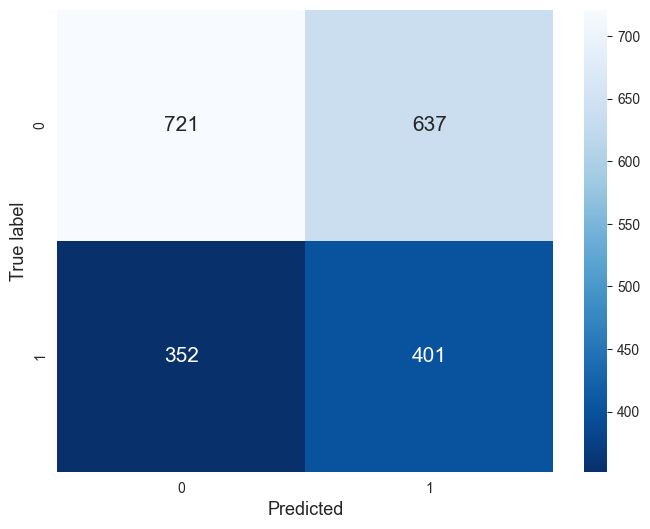

In [47]:
# проверим работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных
y_pred_rf_2 = grid_search_rf_2.predict_proba(X_test)[:, 1]
roc_auc_rf_2 = round(roc_auc_score(y_test, y_pred_rf_2), 4)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_rf_2:.4f}')

y_predict_rf_2 = grid_search_rf_2.predict(X_test)
f1_rf_2 = round(f1_score(y_test, y_predict_rf_2), 4)
print(classification_report(y_test, y_predict_rf_2))

cm_rf_2 = confusion_matrix(y_test, y_predict_rf_2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_2, annot=True, fmt='d', cmap='Blues_r', annot_kws={'size': 15})
plt.ylabel('True label', fontsize=13)
plt.xlabel('Predicted', fontsize=13)
plt.show()

Стало немного лучше:
* Увеличилось количество TP c 103 до 401;
* Стало меньше ошибок 2го рода (было 650, теперь 352).

Но TN уменьшилось с 1282 до 721 и стало больше ошибок 1го рода (было 76, теперь - 637). 

In [48]:
results.loc[2] = ['CatBoost+Undersampler', f1_cb_2, roc_auc_cb_2, 400, 353, 626]
results.loc[3] = ['RandomForest+Undersampler', f1_rf_2, roc_auc_rf_2, 401, 352, 637]
results

,модель,f1,roc_auc,TP,FN,FP
0,CatBoostClassifier,0.2674,0.5767,138,615,141
1,RandomForestClassifier,0.2210,0.5684,103,650,76
2,CatBoost+Undersampler,0.4497,0.5731,400,353,626
3,RandomForest+Undersampler,0.4478,0.5571,401,352,637


### 4.3. Третья модель (c feature_engineering)

Попробуем еще улучшить модель.

Создадим функцию feature_engineering, с помощью которой добавим новые признаки:
* Гипертония `'hypertension'` (категориальный признак) - категория 1, если нормализованное значение любого из давлений > 0.6, что примерно соответствует > 140 мм рт.ст.;
* Пульсовое давление `'pulse_pressure'` (разница между верхним(систолическим) и нижним(диастолическое) давлением в абсолютных значениях);
* Хронические заболевания (комбинация факторов риска) `'metabolic_risk_features'` (значения 0, 1, 2 и 3) - за наличие каждого из хронических заболеваний (ожирение, диабет и гипертония) добавим 1 балл;
* Малоподвижный образ жизни `'high_sedentary'` (более 0.7 - категория 1) и `'low_exercise'` (менее 0.3 - категория 1);
* Вредные привычки и образ жизни `'lifestyle_risk_features'` (значения от 0 до 4) - за наличие каждого пункта (курение, алкогольная зависимость и два признака малоподвижного образа жизни) добавим 1 балл.


И у нас есть признаки, которые можно исключить:
* `'systolic_blood_pressure'`, `'diastolic_blood_pressure'` (заменим их двумя другими признаками ('hypertension', 'pulse_pressure'))
* уровень сахара в крови `'blood_sugar'` (так как есть признак наличия диабета `'diabetes'`);
* уровень дохода `'income'` (не влияет на риск сердечного приступа).

In [49]:
def feature_engineering(df):
        """
        Создание новых признаков на основе имеющихся данных
        """
        df = df.copy()
        
        # Высокое давление (нормализованное значение > 0.6 примерно соответствует 140+ мм рт.ст.)
        df['hypertension'] = ((df['systolic_blood_pressure'] > 0.6) | (df['diastolic_blood_pressure'] > 0.6)).astype(int)

        # Пульсовое давление (разница между верхним(систолическим) и нижним(диастолическое))
        df['pulse_pressure'] = abs(df['systolic_blood_pressure'] - df['diastolic_blood_pressure'])
        
        # Хронические заболевания (комбинация факторов риска)
        metabolic_risk_features = ['obesity', 'diabetes', 'hypertension']
        df['metabolic_risk_score'] = df[metabolic_risk_features].sum(axis=1)

        # Малоподвижный образ жизни
        df['high_sedentary'] = (df['sedentary_hours_per_day'] > 0.7).astype(int)
        df['low_exercise'] = (df['exercise_hours_per_week'] < 0.3).astype(int)
        
        # Вредные привычки и образ жизни
        lifestyle_risk_features = ['smoking', 'alcohol_consumption', 'high_sedentary', 'low_exercise']
        df['lifestyle_risk_score'] = df[lifestyle_risk_features].sum(axis=1)

        return df

In [50]:
df_train_3 = feature_engineering(df_train)
df_train_3 = df_train_3.drop(['blood_sugar', 'income', 'systolic_blood_pressure', 'diastolic_blood_pressure'], axis=1)
df_train_3.head()

,heart_attack_risk_(binary),age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,gender,hypertension,pulse_pressure,metabolic_risk_score,high_sedentary,low_exercise,lifestyle_risk_score
id,,,,,,,,,,,,,,,,,,,,,,,,,,
2664,0,0.359551,0.732143,0.742438,1,1,1,1,1,0.535505,1,1,0,8,0.225704,0.459176,0.979221,3,0.333333,1,1,0.496399,3,0,0,2
9287,0,0.202247,0.325000,0.476627,1,1,0,0,1,0.068690,2,1,0,9,0.289923,0.117053,0.515584,3,0.833333,0,0,0.156864,1,0,1,2
5379,0,0.606742,0.860714,0.559120,1,0,1,1,1,0.944001,2,1,1,6,0.550133,0.373574,0.012987,2,1.000000,0,0,0.017779,2,0,0,2
8222,1,0.730337,0.007143,0.531622,0,0,1,0,1,0.697023,0,0,1,3,0.330962,0.049735,0.131169,0,0.333333,0,0,0.080945,0,0,0,2
4047,1,0.775281,0.757143,0.219982,0,0,1,0,1,0.412878,1,0,0,8,0.524600,0.830405,0.070130,5,1.000000,1,1,0.177494,1,0,0,2


In [51]:
X_3 = df_train_3.drop('heart_attack_risk_(binary)', axis=1)
y_3 = df_train_3['heart_attack_risk_(binary)']

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(
    X_3,
    y_3,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)
print('Размер X_train_3:', X_train_3.shape)
print('Размер X_test_3:', X_test_3.shape)
print('Размер y_train_3:', y_train_3.shape)
print('Размер y_test_3:', y_test_3.shape)

Размер X_train_3: (6331, 25)
Размер X_test_3: (2111, 25)
Размер y_train_3: (6331,)
Размер y_test_3: (2111,)


In [52]:
grid_search_cb_3 = GridSearchCV(
    pipe_final, 
    param_cb, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search_cb_3.fit(X_train_3, y_train_3)

print('Лучшая модель и её параметры:\n\n', grid_search_cb_3.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', round(grid_search_cb_3.best_score_, 4))

Лучшая модель и её параметры:

 Pipeline(steps=[('sampling', RandomUnderSampler(random_state=42)),
                ('models',
                 <catboost.core.CatBoostClassifier object at 0x14ab2a750>)])
Метрика лучшей модели на кросс-валидации: 0.5575


In [53]:
(pd.DataFrame(grid_search_cb_3.cv_results_).sort_values(by='rank_test_score')
    [['rank_test_score', 'mean_test_score', 'params', 'mean_fit_time']])

,rank_test_score,mean_test_score,params,mean_fit_time
1,1,0.557459,"{'models': <catboost.core.CatBoostClassifier object at 0x14a5b2050>, 'models__depth': 10, 'models__iterations': 1000}",38.599579
0,2,0.556882,"{'models': <catboost.core.CatBoostClassifier object at 0x14a5b2050>, 'models__depth': 10, 'models__iterations': 500}",16.659064
3,3,0.551431,"{'models': <catboost.core.CatBoostClassifier object at 0x14a5b2050>, 'models__depth': 12, 'models__iterations': 1000}",74.789447
2,4,0.550792,"{'models': <catboost.core.CatBoostClassifier object at 0x14a5b2050>, 'models__depth': 12, 'models__iterations': 500}",48.893994


Метрика ROC-AUC на тестовой выборке: 0.5781
              precision    recall  f1-score   support

           0       0.68      0.53      0.60      1358
           1       0.39      0.54      0.45       753

    accuracy                           0.54      2111
   macro avg       0.53      0.54      0.52      2111
weighted avg       0.57      0.54      0.55      2111



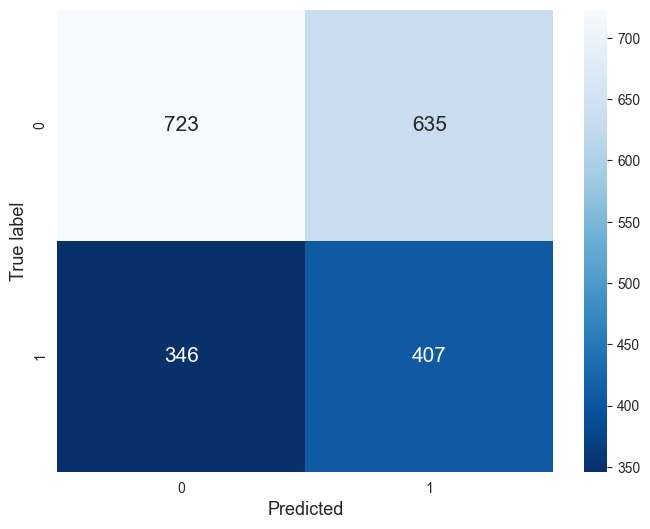

In [54]:
# проверим работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных
y_pred_cb_3 = grid_search_cb_3.predict_proba(X_test_3)[:, 1]
roc_auc_cb_3 = round(roc_auc_score(y_test_3, y_pred_cb_3), 4)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_cb_3:.4f}')

y_predict_cb_3 = grid_search_cb_3.predict(X_test_3)
f1_cb_3 = round(f1_score(y_test_3, y_predict_cb_3), 4)
print(classification_report(y_test_3, y_predict_cb_3))

cm_cb_3 = confusion_matrix(y_test_3, y_predict_cb_3)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cb_3, annot=True, fmt='d', cmap='Blues_r', annot_kws={'size': 15})
plt.ylabel('True label', fontsize=13)
plt.xlabel('Predicted', fontsize=13)
plt.show()

Нужные нам показатели стали немного лучше:
* Увеличилось количество TP c 400 до 407;
* Стало меньше ушибок 2го рода (было 353, теперь 346).

Но TN уменьшилось с 732 до 723 и стало больше ошибок 1го рода (было 626, теперь - 635). 

In [55]:
grid_search_rf_3 = GridSearchCV(
    pipe_final, 
    param_rf, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search_rf_3.fit(X_train_3, y_train_3)

print('Лучшая модель и её параметры:\n\n', grid_search_rf_3.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', round(grid_search_rf_3.best_score_, 4))

Лучшая модель и её параметры:

 Pipeline(steps=[('sampling', RandomUnderSampler(random_state=42)),
                ('models',
                 RandomForestClassifier(class_weight='balanced', max_depth=13,
                                        n_estimators=200, random_state=42))])
Метрика лучшей модели на кросс-валидации: 0.5644


In [56]:
(pd.DataFrame(grid_search_rf_3.cv_results_).sort_values(by='rank_test_score')
    [['rank_test_score', 'mean_test_score', 'params', 'mean_fit_time']])

,rank_test_score,mean_test_score,params,mean_fit_time
7,1,0.564406,"{'models': RandomForestClassifier(class_weight='balanced', random_state=42), 'models__max_depth': 13, 'models__n_estimators': 200}",1.139699
9,2,0.562097,"{'models': RandomForestClassifier(class_weight='balanced', random_state=42), 'models__max_depth': 14, 'models__n_estimators': 200}",1.040003
3,3,0.561636,"{'models': RandomForestClassifier(class_weight='balanced', random_state=42), 'models__max_depth': 11, 'models__n_estimators': 200}",1.048557
2,4,0.561503,"{'models': RandomForestClassifier(class_weight='balanced', random_state=42), 'models__max_depth': 11, 'models__n_estimators': 100}",0.520268
4,5,0.561301,"{'models': RandomForestClassifier(class_weight='balanced', random_state=42), 'models__max_depth': 12, 'models__n_estimators': 100}",0.536371
5,6,0.560975,"{'models': RandomForestClassifier(class_weight='balanced', random_state=42), 'models__max_depth': 12, 'models__n_estimators': 200}",1.092070
8,7,0.559397,"{'models': RandomForestClassifier(class_weight='balanced', random_state=42), 'models__max_depth': 14, 'models__n_estimators': 100}",0.591680
6,8,0.557111,"{'models': RandomForestClassifier(class_weight='balanced', random_state=42), 'models__max_depth': 13, 'models__n_estimators': 100}",0.571206
1,9,0.555901,"{'models': RandomForestClassifier(class_weight='balanced', random_state=42), 'models__max_depth': 10, 'models__n_estimators': 200}",0.962688
0,10,0.553811,"{'models': RandomForestClassifier(class_weight='balanced', random_state=42), 'models__max_depth': 10, 'models__n_estimators': 100}",0.438321


Метрика ROC-AUC на тестовой выборке: 0.5894
              precision    recall  f1-score   support

           0       0.69      0.55      0.61      1358
           1       0.41      0.56      0.47       753

    accuracy                           0.55      2111
   macro avg       0.55      0.55      0.54      2111
weighted avg       0.59      0.55      0.56      2111



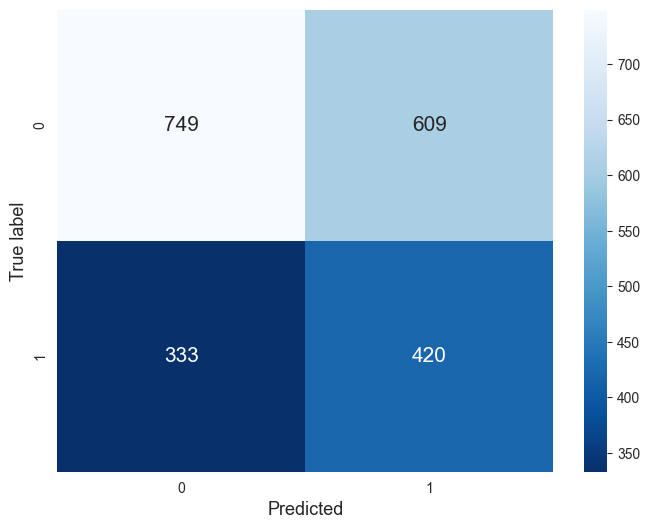

In [57]:
# проверим работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных
y_pred_rf_3 = grid_search_rf_3.predict_proba(X_test_3)[:, 1]
roc_auc_rf_3 = round(roc_auc_score(y_test_3, y_pred_rf_3), 4)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_rf_3:.4f}')

y_predict_rf_3 = grid_search_rf_3.predict(X_test_3)
f1_rf_3 = round(f1_score(y_test_3, y_predict_rf_3), 4)
print(classification_report(y_test_3, y_predict_rf_3))

cm_rf_3 = confusion_matrix(y_test_3, y_predict_rf_3)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_3, annot=True, fmt='d', cmap='Blues_r', annot_kws={'size': 15})
plt.ylabel('True label', fontsize=13)
plt.xlabel('Predicted', fontsize=13)
plt.show()

Здесь тоже нужные нам показатели стали немного лучше:
* Увеличилось количество TP c 401 до 420;
* Стало меньше ушибок 2го рода (было 352, теперь 333);
* Увеличилось количество TN (было 721, теперь 749).
* Стало меньше ошибок 1го рода (было 637, теперь - 609). 

In [58]:
results.loc[4] = ['CatBoost+Undersampler+FE', f1_cb_3, roc_auc_cb_3, 407, 346, 635]
results.loc[5] = ['RandomForest+Undersampler+FE', f1_rf_3, roc_auc_rf_3, 420, 333, 609]
results

,модель,f1,roc_auc,TP,FN,FP
0,CatBoostClassifier,0.2674,0.5767,138,615,141
1,RandomForestClassifier,0.2210,0.5684,103,650,76
2,CatBoost+Undersampler,0.4497,0.5731,400,353,626
3,RandomForest+Undersampler,0.4478,0.5571,401,352,637
4,CatBoost+Undersampler+FE,0.4535,0.5781,407,346,635
5,RandomForest+Undersampler+FE,0.4714,0.5894,420,333,609


Как видно из сводной таблицы, лучшей моделью является последняя модель RandomForestClassifier() c undersampling и добавлением новых признаков.

### 4.4. Подбор порога вероятности

Ошибки 2го рода для нас критичнее, так как предсказание отсутствия риска сердечного приступа, если риск на самом деле есть, может стоить кому-то жизни. Но, при этом, ошибочное предсказание повышенного риска тому, у кого его нет (ошибки 1го рода) тоже должны быть не слишком высокими.

Подберем порог  вероятности, чтобы снизить ошибки 2го рода и большему количеству значений присваивать 1 класс, и не слишком сильно увеличить ошибки 1го рода. 

In [59]:
def threshold_choice(thresholds, data):
    '''
    Функция выводит таблицу с  посчитанными метриками для каждого порога
    '''
    result_data = pd.DataFrame(columns=['порог', 'f1', 'precision', 'recall', 'количество_FN', 
                                        'количество_TP','число_предсказанных_объектов', 'всего_объектов_класса_1'])

    for i in thresholds:
        column_name = 'y_pred_' + str(i)
        f1 = round(f1_score(data['y_test'], data[column_name]), 3)
        precision = round(precision_score(data['y_test'], data[column_name]), 3)
        recall = round(recall_score(data['y_test'], data[column_name]), 3)
        # Число предсказанных объектов
        predicted_objects = data[column_name].sum()
        # Всего объектов класса 1
        total_objects_class_1 = data['y_test'].sum()
        # Количество ложноотрицательных предсказаний (FN)
        false_negatives = data.loc[(data[column_name] == 0) & (data['y_test'] == 1)].shape[0]
        # Количество истинноположительных предсказаний (TP)
        true_positives = data.loc[(data[column_name] == 1) & (data['y_test'] == 1)].shape[0]
        # Добавляем результаты в датафрейм
        new_row = pd.DataFrame({
            'порог': [i],
            'f1': [f1],
            'precision': [precision],
            'recall': [recall],
            'количество_FN': [false_negatives],
            'количество_TP': [true_positives],
            'число_предсказанных_объектов': [predicted_objects],
            'всего_объектов_класса_1': [total_objects_class_1],
        })
        
        result_data = pd.concat([result_data, new_row], ignore_index=True)

    return result_data

In [60]:
y_proba = grid_search_rf_3.predict_proba(X_test_3)[:, 1]
data = pd.DataFrame(zip(y_test_3, y_proba), 
                      columns = ['y_test', 'y_proba']).sort_values(by='y_proba', ascending=False)
thresholds = [round(i, 2) for i in np.linspace(0.35, 0.51, num=16, endpoint=False)]
columns = []
for i in thresholds:
    columns.append('y_pred_' + str(i))
    data['y_pred_' + str(i)] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)
data.head()    

,y_test,y_proba,y_pred_0.35,y_pred_0.36,y_pred_0.37,y_pred_0.38,y_pred_0.39,y_pred_0.4,y_pred_0.41,y_pred_0.42,y_pred_0.43,y_pred_0.44,y_pred_0.45,y_pred_0.46,y_pred_0.47,y_pred_0.48,y_pred_0.49,y_pred_0.5
140,1,0.876666,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1096,1,0.855010,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
427,1,0.836735,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
864,1,0.800373,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1613,1,0.785021,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [61]:
threshold_df = threshold_choice(thresholds, data)
threshold_df

,порог,f1,precision,recall,количество_FN,количество_TP,число_предсказанных_объектов,всего_объектов_класса_1
0,0.35,0.538,0.368,0.999,1,752,2041,753
1,0.36,0.540,0.370,0.997,2,751,2028,753
2,0.37,0.541,0.371,0.995,4,749,2018,753
3,0.38,0.541,0.372,0.991,7,746,2006,753
4,0.39,0.540,0.372,0.984,12,741,1990,753
5,0.40,0.538,0.372,0.976,18,735,1977,753
6,0.41,0.538,0.372,0.965,26,727,1952,753
7,0.42,0.539,0.375,0.954,35,718,1913,753
8,0.43,0.539,0.379,0.932,51,702,1852,753
9,0.44,0.533,0.378,0.903,73,680,1797,753


Остановимся на пороге в 0.46. Тогда количество ошибок 2го рода составит 138 (около 18%), но при этом хотя бы 30% значений класса 0 модель будет классифицировать правильно.

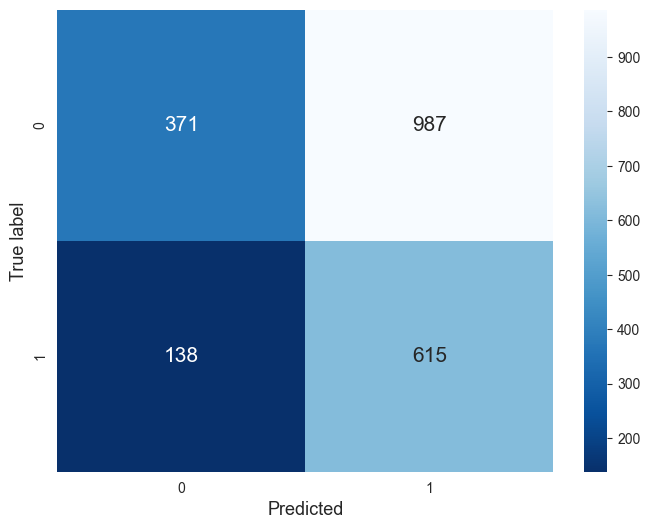

In [62]:
best_threshold = 0.46
y_pred_new_threshold = (grid_search_rf_3.predict_proba(X_test_3)[:, 1] >= best_threshold).astype(int)
f1_rf_4 = round(f1_score(y_test_3, y_pred_new_threshold), 4) 

cm_4 = confusion_matrix(y_test_3, y_pred_new_threshold)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_4, annot=True, fmt='d', cmap='Blues_r', annot_kws={'size': 15})
plt.ylabel('True label', fontsize=13)
plt.xlabel('Predicted', fontsize=13)
plt.show()

In [63]:
print(classification_report(y_test_3, y_pred_new_threshold))

              precision    recall  f1-score   support

           0       0.73      0.27      0.40      1358
           1       0.38      0.82      0.52       753

    accuracy                           0.47      2111
   macro avg       0.56      0.54      0.46      2111
weighted avg       0.61      0.47      0.44      2111



In [64]:
results.loc[6] = ['RandomForest+Undersampler+FE+ПодборПорога', f1_rf_4, roc_auc_rf_3, 615, 138, 987]
results

,модель,f1,roc_auc,TP,FN,FP
0,CatBoostClassifier,0.2674,0.5767,138,615,141
1,RandomForestClassifier,0.2210,0.5684,103,650,76
2,CatBoost+Undersampler,0.4497,0.5731,400,353,626
3,RandomForest+Undersampler,0.4478,0.5571,401,352,637
4,CatBoost+Undersampler+FE,0.4535,0.5781,407,346,635
5,RandomForest+Undersampler+FE,0.4714,0.5894,420,333,609
6,RandomForest+Undersampler+FE+ПодборПорога,0.5223,0.5894,615,138,987


<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'>Модель, конечно, предсказывает не лучше, чем случайное угадывание. Но с такими данными даже не знаю, как еще можно ее улучшить. Поэтому оставлю так.</font>
</div>

***Лучшей моделью является:***
* RandomForestClassifier(class_weight='balanced', random_state=42);
* max_depth: 13;
* n_estimators: 200;
* порог вероятности: 0.46.

### Вывод:

Мы подготовили и с помощью GridSearch обучили модели CatBoostClassifier() и RandomForestClassifier() c разными гиперпараметрами.

Чтобы улучшить модель мы использовали RandomUnderSampler (для устранения дисбаланса в целевом признаке), а также добавили несколько новых признаков ('hypertension', 'pulse_pressure', 'metabolic_risk_features', 'high_sedentary', 'low_exercise', 'lifestyle_risk_features') и удалили несколько ненужных признаков.

Также мы подообрали оптимальный порог вероятности, чтобы уменьшить количество ошибок 2го уровня (когда модель неправильно отнесла наличие риска сердечного приступа к категории '0').

В итоге, ***лучшей моделью*** оказалась:
* `RandomForestClassifier(class_weight='balanced', random_state=42)`;
* `max_depth: 13`;
* `n_estimators: 200`;
* `порог вероятности: 0.46`.

Метрика ROC-AUC по ней составила 0.56 на кросс-валидации и 0.59 на тестовой выборке.

## 5. Подготовка данных для прогноза

In [65]:
def prepare_data(data):
    '''
    Подготавливает данные тестовой выборки для получения предсказаний
    '''
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    data = data.drop(['unnamed:_0'] , axis=1).set_index('id')
    data = data.dropna()

    columns_change_type = ['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'previous_heart_problems', \
                           'medication_use', 'stress_level', 'physical_activity_days_per_week']
    
    data[columns_change_type] = data[columns_change_type].astype(int)
    data['gender'] = data['gender'].apply(lambda x: 1 if x == 'Male' else 0)
    data['heart_rate'] = data['heart_rate'] * 10
    data = data.drop(['ck-mb', 'troponin'], axis=1)
    data = feature_engineering(data)
    data = data.drop(['blood_sugar', 'income', 'systolic_blood_pressure', 'diastolic_blood_pressure'], axis=1)
    
    return data

In [66]:
data_test = pd.read_csv('./data/heart_test.csv')
test_df = prepare_data(data_test)
info_df(test_df)

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,gender,hypertension,pulse_pressure,metabolic_risk_score,high_sedentary,low_exercise,lifestyle_risk_score
id,,,,,,,,,,,,,,,,,,,,,,,,,
7746,0.494382,0.264286,0.623281,0,1,1,1,1,0.361618,2,0,0,8,0.194370,0.283490,0.306494,1,0.333333,1,0,0.088222,1,0,0,2
4202,0.224719,0.953571,0.824931,1,0,0,1,0,0.996483,2,1,1,5,0.329888,0.467036,0.087013,0,0.166667,0,1,0.261365,3,0,0,0
6632,0.629213,0.092857,0.641613,0,1,1,1,0,0.995561,0,0,0,10,0.780075,0.409366,0.205195,7,1.000000,1,1,0.321005,2,1,0,2
4639,0.460674,0.567857,0.559120,1,1,1,1,1,0.437277,0,0,0,10,0.785071,0.910261,0.163636,0,0.666667,0,1,0.486122,3,1,0,3
4825,0.719101,0.485714,0.229148,1,0,1,0,1,0.514920,0,0,0,7,0.070919,0.758924,0.580519,5,0.000000,1,0,0.017554,1,0,0,2
1076,0.561798,0.792857,0.265811,1,1,1,1,0,0.774470,2,0,1,8,0.044114,0.723416,0.362338,1,0.666667,1,0,0.431733,2,0,0,1
5020,0.674157,0.853571,0.192484,1,1,1,0,1,0.149123,1,0,0,8,0.305998,0.696128,0.211688,3,0.000000,1,0,0.011028,1,0,1,3
4267,0.539326,0.335714,0.366636,1,1,1,0,1,0.329720,1,1,0,1,0.377016,0.484368,0.835065,7,0.666667,1,1,0.166017,2,0,0,2
4003,0.449438,0.328571,0.751604,1,0,1,0,0,0.487405,2,1,0,10,0.089371,0.409407,0.819481,2,0.166667,1,1,0.247187,2,0,0,1


************************************************** 

<class 'pandas.core.frame.DataFrame'>
Index: 935 entries, 7746 to 6521
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              935 non-null    float64
 1   cholesterol                      935 non-null    float64
 2   heart_rate                       935 non-null    float64
 3   diabetes                         935 non-null    int64  
 4   family_history                   935 non-null    int64  
 5   smoking                          935 non-null    int64  
 6   obesity                          935 non-null    int64  
 7   alcohol_consumption              935 non-null    int64  
 8   exercise_hours_per_week          935 non-null    float64
 9   diet                             935 non-null    int64  
 10  previous_heart_problems          935 non-null    int64  
 11  medication_use                  

None

************************************************** 

Количество пропущенных значений:
 age                                0
cholesterol                        0
heart_rate                         0
diabetes                           0
family_history                     0
smoking                            0
obesity                            0
alcohol_consumption                0
exercise_hours_per_week            0
diet                               0
previous_heart_problems            0
medication_use                     0
stress_level                       0
sedentary_hours_per_day            0
bmi                                0
triglycerides                      0
physical_activity_days_per_week    0
sleep_hours_per_day                0
gender                             0
hypertension                       0
pulse_pressure                     0
metabolic_risk_score               0
high_sedentary                     0
low_exercise                       0
lifestyle_risk_score     

In [67]:
test_df['prediction'] = (grid_search_rf_3.predict_proba(test_df)[:, 1] >= best_threshold).astype(int)
test_df.sample(10)

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,gender,hypertension,pulse_pressure,metabolic_risk_score,high_sedentary,low_exercise,lifestyle_risk_score,prediction
id,,,,,,,,,,,,,,,,,,,,,,,,,,
8514,0.471910,0.767857,0.623281,1,0,1,1,1,0.730985,2,0,1,3,0.072613,0.502439,0.807792,3,1.000000,1,0,0.118380,2,0,0,2,0
92,0.808989,0.910714,0.238313,1,1,1,0,0,0.173253,1,0,1,3,0.155423,0.035940,0.232468,6,1.000000,1,0,0.280645,1,0,1,2,1
50,0.584270,0.785714,0.449129,1,0,1,1,0,0.455235,2,1,1,1,0.518151,0.913228,0.931169,1,1.000000,1,1,0.055889,3,0,0,1,1
2611,0.561798,0.617857,0.494959,1,0,1,0,0,0.416830,0,1,0,5,0.989819,0.020538,0.701299,1,0.666667,1,0,0.016054,1,1,0,2,1
4684,0.494382,0.257143,0.366636,0,1,1,0,1,0.091013,1,0,1,1,0.402646,0.479729,0.937662,1,0.000000,1,1,0.188972,1,0,1,3,1
6911,0.382022,0.628571,0.320807,0,0,1,1,0,0.636901,1,0,1,7,0.193113,0.357869,0.359740,0,0.500000,0,0,0.029407,1,0,0,1,1
9054,0.494382,0.682143,0.247479,1,0,1,0,0,0.821332,1,1,0,3,0.311900,0.987663,0.332468,6,1.000000,1,1,0.198350,2,0,0,1,1
6613,0.539326,0.257143,0.302475,1,1,1,1,1,0.517756,1,1,1,6,0.843054,0.408285,0.723377,6,1.000000,1,0,0.018605,2,1,0,3,0
7661,0.752809,0.146429,0.229148,1,1,1,0,0,0.377162,1,0,1,7,0.004957,0.457527,0.075325,4,0.000000,0,0,0.066317,1,0,0,1,1


In [68]:
# предсказания по строкам, в которых не было пропусков во входных признаках
predictions = test_df['prediction'].reset_index()
predictions

,id,prediction
0,7746,0
1,4202,1
2,6632,0
3,4639,0
4,4825,1
...,...,...
930,9271,1
931,8012,1
932,2456,1
933,4984,0


In [72]:
# предсказания по всем строкам (по тем строкам, где были пропуски предсказания заменены заглушкой -100)
predictions_full = pd.merge(data_test, predictions, on='id', how='left')[['id', 'prediction']]
predictions_full = predictions_full.fillna(-100).astype(int)
predictions_full

,id,prediction
0,7746,0
1,4202,1
2,6632,0
3,4639,0
4,4825,1
...,...,...
961,9271,1
962,8012,1
963,2456,1
964,4984,0


In [ ]:
# сохранение модели
with open('model.pickle', 'wb') as wf:
  pickle.dump(grid_search_rf_3, wf)

In [ ]:
predictions.to_csv('predictions/predictions.csv')
predictions_full.to_csv('predictions/predictions_full.csv')

## Общий вывод

В рамках проекта по предсказанию рисков сердечного приступа был изучен датасет из открытого источника с  данными о пациентах (возраст, привычки, состояние здоровья, анализ крови).

***Целью данного проекта*** было разработать модель машинного обучения для предсказания риска сердечного приступа, а также подготовить предсказания на тестовой выборке.

В ходе исследования была проведена ***предобработка данных***:
* были переименованы столбцы и приведены к единому стилю написания;
* обработаны пропущенные значения;
* явных дубликатов не выявлено;
* были удалены неочевидные значения в столбце `'gender'`;
* изменены типы данных.

Мы провели ***исследовательский анализ данных***, в ходе которого изучили количественные и категориальные признаки:
* Значения тренировочных и тестовых данных очень близки.
* Практически у всех признаков (`'age'`, `'cholesterol'`, `'heart_rate'`, `'exercise_hours_per_week'`, `'sedentary_hours_per_day'`, `'income'`, `'bmi'`, `'triglycerides'`, `'sleep_hours_per_day'`, `'systolic_blood_pressure'`, `'diastolic_blood_pressure'`)  распределение равномерное, выбросы отсутствуют. Так как значения уже нормализованы, они лежат в диапазоне от 0 до 1. Но только у признака `'heart_rate'` значения в 10 раз меньше и распределены в диапазоне от 0.02 до 0.08.
* Данные у дискретных признаков `'physical_activity_days_per_week'` и `'sleep_hours_per_day'` также распределены равномерно, но только у 
`'sleep_hours_per_day'` значения нормализованы и лежат в диапазоне от 0 до 1, а у `'physical_activity_days_per_week'` значения не нормализованы и лежат в диапазоне от 0 до 7.
* Признаки `'ck-mb'`  и `'troponin'` - это показатели, повышенный уровень которых является следствием инфаркта, а не фактором, увеличивающим риск - утечка целевого признака. 
* Больше половины значений разницы между верхним(систолическим) и нижним(диастолическим) давлением отрицательные, чего быть не должно. Возможно, значения верхнего(систолического) и нижнего(диастолического) давления были переставлены местами.
* Есть дисбаланс классов (доля значений с наличием риска сердечного приступа почти в два раза меньше, чем с отсутствием риска сердечного приступа).

Также был проведен ***корреляционный анализ***, который показал:
* что у таргета практически отсутсвуют корреляционные связи с любым из признаков.
* Мультиколлинеарности между входными признаками не обнаружено.
* Не видно какой-либо зависимости между таргетом и количественными признаками. По категориальным признакам: значений с классом 1 немного больше у пациентов с диабетом, курящих, употребляющих алкоголь и мужчин, но, при этом, и общее количество записей с этими значениями выше (т.е. пациентов с диабетом больше, чем без диабета; мужчин больше, чем женщин и т.д.).

В процессе ***поиска лучшей модели*** мы подготовили и с помощью GridSearch обучили модели CatBoostClassifier() и RandomForestClassifier() c разными гиперпараметрами.

Чтобы улучшить модель мы использовали RandomUnderSampler (для устранения дисбаланса в целевом признаке), а также добавили несколько новых признаков ('hypertension', 'pulse_pressure', 'metabolic_risk_features', 'high_sedentary', 'low_exercise', 'lifestyle_risk_features') и удалили несколько ненужных признаков.

Также мы подообрали оптимальный порог вероятности, чтобы уменьшить количество ошибок 2го уровня (когда модель неправильно отнесла наличие риска сердечного приступа к категории '0').

В итоге, **лучшей моделью** оказалась:
* `RandomForestClassifier(class_weight='balanced', random_state=42)`;
* `max_depth: 13`;
* `n_estimators: 200`;
* `порог вероятности: 0.46`.

Метрика ROC-AUC по ней составила 0.56 на кросс-валидации и 0.59 на тестовой выборке.